## 8. [20%] Preparación de datos:

# Los datos entregados por la UTPN (Unión temporal peajes nacionales) se encuentran en la carpeta trafico PMU, los datos los archivos de excel por estación y se tienen documentos desde diciembre de 2021 a septiembre de 2025.

# Se realiza consolidado de información.

In [7]:
import os
import re
from pathlib import Path
import unicodedata
import datetime as dt

import pandas as pd
from openpyxl import load_workbook

In [8]:
# -------------------------------------------------------------------
# CONFIG
# -------------------------------------------------------------------
BASE_DIR = Path(
    r"/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU")

YEARS_TO_PROCESS = [2021, 2022, 2023, 2024, 2025]

SPANISH_MONTHS = [
    "ENERO", "FEBRERO", "MARZO", "ABRIL", "MAYO", "JUNIO",
    "JULIO", "AGOSTO", "SEPTIEMBRE", "SETIEMBRE",
    "OCTUBRE", "NOVIEMBRE", "DICIEMBRE",
]

TOTAL_S1_HEADER_CANDIDATES = [
    "TOTAL CON EXENTOS SENTIDO 1",
    "TOTAL CON EXENTOS S1",
    "TOTAL SENTIDO 1 CON EXENTOS",
    "TOTAL SENTIDO 1",
    "TOTAL S1",
    "TOTAL CON EJES SENTIDO 1",
    "TOTAL CON EJES S1",
    "TOTAL SENTIDO 1 CON EJES",
    "TOTAL CON EJES",
    "TOTAL CON EXENTOS",
]

TOTAL_S2_HEADER_CANDIDATES = [
    "TOTAL CON EXENTOS SENTIDO 2",
    "TOTAL CON EXENTOS S2",
    "TOTAL SENTIDO 2 CON EXENTOS",
    "TOTAL SENTIDO 2",
    "TOTAL S2",
    "TOTAL CON EJES SENTIDO 2",
    "TOTAL CON EJES S2",
    "TOTAL SENTIDO 2 CON EJES",
    "TOTAL CON EJES",
    "TOTAL CON EXENTOS",
]

# -------------------------------------------------------------------
# HELPERS
# -------------------------------------------------------------------

def normalize_text(value) -> str:
    if value is None:
        return ""
    if not isinstance(value, str):
        value = str(value)
    value = value.strip()
    if not value:
        return ""
    value = ''.join(
        c for c in unicodedata.normalize("NFKD", value)
        if not unicodedata.combining(c)
    )
    value = value.lower().replace(" ", "")
    return value

def is_month_folder(name: str) -> bool:
    return any(month in name.upper() for month in SPANISH_MONTHS)

def looks_like_month_year(text: str) -> bool:
    if not isinstance(text, str):
        return False
    clean = ''.join(
        c for c in unicodedata.normalize("NFKD", text)
        if not unicodedata.combining(c)
    ).upper()
    has_month = any(month in clean for month in SPANISH_MONTHS)
    has_year = re.search(r"\d{4}", clean) is not None
    return has_month and has_year

def parse_date_cell(value):
    if isinstance(value, (dt.date, dt.datetime, pd.Timestamp)):
        return pd.to_datetime(value)
    if isinstance(value, str):
        s = re.sub(r"\s*(TC|TAB|NT)\s*$", "", value.strip(), flags=re.IGNORECASE).strip()
        if not s:
            return None
        parsed = pd.to_datetime(s, dayfirst=True, errors="coerce")
        return None if pd.isna(parsed) else parsed
    return None

# -------------------------------------------------------------------
# COLUMN DETECTION
# -------------------------------------------------------------------

def find_columns(ws):
    max_rows = min(20, ws.max_row)
    max_cols = min(60, ws.max_column)

    date_col = None
    total_s1_col = None
    total_s2_col = None

    s1_norm = [normalize_text(h) for h in TOTAL_S1_HEADER_CANDIDATES]
    s2_norm = [normalize_text(h) for h in TOTAL_S2_HEADER_CANDIDATES]

    for r in range(1, max_rows + 1):
        for c in range(1, max_cols + 1):
            val = ws.cell(row=r, column=c).value
            if val is None:
                continue
            norm = normalize_text(val)
            if not norm:
                continue

            if date_col is None and ("dia/mes" in norm or "recaudo" in norm):
                date_col = c

            if total_s1_col is None:
                if any(candidate in norm for candidate in s1_norm):
                    total_s1_col = c

            if total_s2_col is None:
                if any(candidate in norm for candidate in s2_norm):
                    total_s2_col = c

        if date_col and total_s1_col and total_s2_col:
            break

    return date_col, total_s1_col, total_s2_col

# -------------------------------------------------------------------
# TOLL NAME LOGIC
# -------------------------------------------------------------------

def infer_toll_name_from_filename(path: Path) -> str | None:
    stem = re.sub(r'^\s*\d+\s*[\.\-]?\s*', '', path.stem)
    stem = re.sub(r'(?i)trafico\s+horario\s+sentido', '', stem)
    stem = re.sub(r'^[\s\.\-]+', '', stem).strip()
    return stem or None

# -------------------------------------------------------------------
# FILE EXTRACTION
# -------------------------------------------------------------------

def extract_from_file(path: Path):

    try:
        wb = load_workbook(path, data_only=True)
    except Exception as e:
        print(f"[FILE SKIPPED] Cannot open file: {path} | Error: {e}")
        return []

    # ---- Toll name (silent failures) ----
    toll_name = None
    try:
        ws_tr = wb["TRAFYREC"]
        toll_candidate = ws_tr["A2"].value
    except Exception:
        toll_candidate = None

    if isinstance(toll_candidate, str) and not toll_candidate.strip():
        toll_candidate = None

    if isinstance(toll_candidate, str) and looks_like_month_year(toll_candidate):
        toll_candidate = None

    if toll_candidate:
        toll_name = toll_candidate.strip()
    else:
        inferred = infer_toll_name_from_filename(path)
        toll_name = inferred if inferred else None   # **NO PRINTING HERE**

    # ---- CONSOL MES ----
    try:
        ws = wb["CONSOL MES"]
    except KeyError:
        print(f"[FILE SKIPPED] Sheet 'CONSOL MES' not found in file: {path}")
        return []

    date_col, s1_col, s2_col = find_columns(ws)

    if not date_col:
        print(f"[WARN] Date column not found in CONSOL MES for file: {path}")
        return []

    if not s1_col:
        print(f"[WARN] TOTAL column for SENTIDO 1 not found in file: {path} - assuming 0")

    if not s2_col:
        print(f"[WARN] TOTAL column for SENTIDO 2 not found in file: {path} - assuming 0")

    records = []
    started = False
    source = str(path)

    for r in range(1, ws.max_row + 1):
        raw_date = ws.cell(row=r, column=date_col).value
        parsed_date = parse_date_cell(raw_date)

        if not started:
            if parsed_date is not None:
                started = True
            else:
                continue

        if parsed_date is None:
            break

        total_s1 = ws.cell(row=r, column=s1_col).value if s1_col else 0
        total_s2 = ws.cell(row=r, column=s2_col).value if s2_col else 0

        # skip blank rows only when both columns exist and both blanks
        if s1_col and s2_col:
            def is_blank(x): return x is None or (isinstance(x, str) and not x.strip())
            if is_blank(total_s1) and is_blank(total_s2):
                continue

        records.append(
            {
                "fecha": parsed_date,
                "total_sentido_1": total_s1,
                "total_sentido_2": total_s2,
                "toll_name": toll_name,
                "source_file": source,
            }
        )

    return records

# -------------------------------------------------------------------
# MAIN WALK
# -------------------------------------------------------------------

def build_dataframe(base_dir: Path) -> pd.DataFrame:
    df = pd.DataFrame(columns=["fecha", "total_sentido_1", "total_sentido_2", "toll_name", "source_file"])

    for year_name in os.listdir(base_dir):
        if not year_name.isdigit():
            continue

        year_path = base_dir / year_name
        if not year_path.is_dir():
            continue

        if int(year_name) not in YEARS_TO_PROCESS:
            continue

        print(f"[INFO] Processing year folder: {year_path}")

        for month_name in os.listdir(year_path):
            month_path = year_path / month_name

            if not month_path.is_dir():
                continue
            if not is_month_folder(month_name):
                continue

            for fname in os.listdir(month_path):
                if "Trafico Horario Sentido" not in fname:
                    continue
                if not fname.lower().endswith((".xlsx", ".xlsm", ".xls")):
                    continue

                file_path = month_path / fname

                try:
                    records = extract_from_file(file_path)
                except Exception as e:
                    print(f"[FILE SKIPPED] Error processing file: {file_path} | Error: {e}")
                    continue

                if not records:
                    continue

                df = pd.concat([df, pd.DataFrame(records)], ignore_index=True)

    return df

# -------------------------------------------------------------------
# EXECUTION ENTRY POINT
# -------------------------------------------------------------------

if __name__ == "__main__":
    df = build_dataframe(BASE_DIR)
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True, errors="coerce")
    df.to_excel("trafico_consolidado.xlsx", index=False)


[INFO] Processing year folder: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2022


/var/folders/v8/w_y39whj49513hl9g4csqr3m0000gn/T/ipykernel_8594/2650893262.py:269: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(records)], ignore_index=True)


[FILE SKIPPED] Cannot open file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2022/01. ENERO 2022/~$Trafico Horario Sentido CASABLANCA.xlsx | Error: File is not a zip file
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2022/10. OCTUBRE 2022/Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2022/08. AGOSTO 2022/Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2022/09. SEPTIEMBRE 2022/Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[WARN] TOTAL column for SENTIDO 2 not found in

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2025/1 Enero de 2025/21. Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2025/5 Mayo de 2025/21. Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[INFO] Processing year folder: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2024
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/Trafico_PMU/2024/ABRIL 2024/21. Trafico Horario Sentido LA PARADA.xlsx - assuming 0
[WARN] TOTAL column for SENTIDO 2 not found in file: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDato

## Carga del trafico consolidado

In [3]:
!pip install holidays requests
!pip install holidays

In [4]:
import pandas as pd
import numpy as np
import holidays
import requests
from datetime import datetime

# Ruta al archivo (ajusta según donde lo tengas)
EXCEL_PATH = "trafico_consolidado.xlsx"  # por ejemplo

# Lectura del Excel
df_raw = pd.read_excel(EXCEL_PATH)

print(df_raw.shape)
df_raw.head()

(40217, 5)


,fecha,total_sentido_1,total_sentido_2,toll_name,source_file
0,2022-01-01,3273,1779,OIBA,/Users/nicolasalonsogonzalezochoa/Documents/NA...
1,2022-01-02,9033,3967,OIBA,/Users/nicolasalonsogonzalezochoa/Documents/NA...
2,2022-01-03,9122,4198,OIBA,/Users/nicolasalonsogonzalezochoa/Documents/NA...
3,2022-01-04,8260,3841,OIBA,/Users/nicolasalonsogonzalezochoa/Documents/NA...
4,2022-01-05,7899,3956,OIBA,/Users/nicolasalonsogonzalezochoa/Documents/NA...


## Limpieza básica, tipos y filtrado de fechas

In [7]:
df = df_raw.copy()

# 1. Fecha como datetime normalizada
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce').dt.normalize()

# 2. Filtrar desde 2022
df = df[df['fecha'] >= "2022-01-01"].copy()

# 3. Eliminar columna archivo si existe
df = df.drop(columns=['archivo'], errors='ignore')

print("Columnas ANTES del renombrado:", df.columns.tolist())

# 4. Renombrar columnas AL FORMATO QUE QUEREMOS
rename_map = {
    'toll_name': 'peaje',
    'total_sentido_1': 'sentido_1',
    'total_sentido_2': 'sentido_2'
}

df = df.rename(columns=rename_map)

# 5. Crear columna total si aún no existe
if 'total' not in df.columns:
    df['total'] = df['sentido_1'].fillna(0) + df['sentido_2'].fillna(0)

print("Columnas DESPUÉS del renombrado:", df.columns.tolist())

# 6. Ahora sí puedo reordenar SIN ERROR
df = df[['fecha', 'peaje', 'sentido_1', 'sentido_2', 'total']]

# 7. Función para limpiar números
def to_int_no_decimals(x):
    if pd.isna(x):
        return 0
    s = str(x).strip()
    for sep in ('.', ','):
        idx = s.find(sep)
        if idx != -1:
            s = s[:idx]
            break
    clean = []
    for i, ch in enumerate(s):
        if ch.isdigit():
            clean.append(ch)
        elif ch in ['-','+'] and i == 0:
            clean.append(ch)
    clean = ''.join(clean)
    if clean in ['', '-', '+']:
        return 0
    try:
        return int(clean)
    except ValueError:
        return 0

for col in ['sentido_1', 'sentido_2', 'total']:
    df[col] = df[col].apply(to_int_no_decimals).astype(int)

df.dtypes


Columnas ANTES del renombrado: ['fecha', 'total_sentido_1', 'total_sentido_2', 'toll_name', 'source_file']
Columnas DESPUÉS del renombrado: ['fecha', 'sentido_1', 'sentido_2', 'peaje', 'source_file', 'total']


fecha        datetime64[ns]
peaje                object
sentido_1             int64
sentido_2             int64
total                 int64
dtype: object

## Se agrupan por fecha y estación; se suman los duplicados

In [8]:
# Agrupar por fecha y peaje, sumando las columnas numéricas
df_grouped = (
    df
    .groupby(['fecha', 'peaje'], as_index=False)[['sentido_1', 'sentido_2', 'total']]
    .sum()
)

# Ordenar por fecha (más antigua a más reciente) y por peaje
df_grouped = df_grouped.sort_values(['fecha', 'peaje']).reset_index(drop=True)

df_grouped.head(20)

,fecha,peaje,sentido_1,sentido_2,total
0,2022-01-01,AGUAS NEGRASdef,4596,2810,7406
1,2022-01-01,CASABLANCA,7845,4248,12093
2,2022-01-01,COCORNA (EL SANTUARIO),5649,3034,8683
3,2022-01-01,CURITÍ,4016,1988,6004
4,2022-01-01,LA GOMEZ,3761,2342,6103
5,2022-01-01,LA PARADA,7773,7773,15546
6,2022-01-01,LOBOGUERRERO,1748,1036,2784
7,2022-01-01,LOS CUROS,3824,1766,5590
8,2022-01-01,MORRISON,5241,3075,8316
9,2022-01-01,OIBA,3273,1779,5052


## Clasificación de tipo de dia.

In [9]:
# Determinar rango de años presente en los datos
years = sorted(df_grouped['fecha'].dt.year.unique())
print("Años en los datos:", years)

# Calendario de festivos de Colombia
co_holidays = holidays.country_holidays('CO', years=years)

def clasificar_dia(fecha):
    """
    Devuelve:
    - 'festivo' si es festivo en Colombia
    - 'fin_de_semana' si es sábado o domingo
    - 'entre_semana' en caso contrario
    """
    # fecha es Timestamp; usamos .date() para compararlo con el set de festivos
    d = fecha.date()
    if d in co_holidays:
        return 'festivo'
    elif fecha.weekday() >= 5:  # 5=sábado, 6=domingo
        return 'fin_de_semana'
    else:
        return 'entre_semana'

df_grouped['tipo_dia'] = df_grouped['fecha'].apply(clasificar_dia)

df_grouped[['fecha', 'peaje', 'tipo_dia']].head(20)

Años en los datos: [np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]


,fecha,peaje,tipo_dia
0,2022-01-01,AGUAS NEGRASdef,festivo
1,2022-01-01,CASABLANCA,festivo
2,2022-01-01,COCORNA (EL SANTUARIO),festivo
3,2022-01-01,CURITÍ,festivo
4,2022-01-01,LA GOMEZ,festivo
5,2022-01-01,LA PARADA,festivo
6,2022-01-01,LOBOGUERRERO,festivo
7,2022-01-01,LOS CUROS,festivo
8,2022-01-01,MORRISON,festivo
9,2022-01-01,OIBA,festivo


## Se carga el precio del dolar para validar a futuro alguna correlación

In [15]:
# Rango de fechas que necesitamos
start_date = df_grouped['fecha'].min().strftime("%Y-%m-%d")
end_date   = df_grouped['fecha'].max().strftime("%Y-%m-%d")
print("Rango de fechas TRM:", start_date, "a", end_date)

TRM_ENDPOINT = "https://www.datos.gov.co/resource/32sa-8pi3.json"

params = {
    # Campos que queremos: vigenciadesde (fecha) y valor (TRM)
    "$select": "vigenciadesde,valor",
    "$where": f"vigenciadesde between '{start_date}' and '{end_date}'",
    "$order": "vigenciadesde ASC",
    "$limit": 5000  # suficiente para varios años de datos diarios
}

response = requests.get(TRM_ENDPOINT, params=params)
response.raise_for_status()
trm_json = response.json()

trm_df = pd.DataFrame(trm_json)
if not trm_df.empty:
    trm_df['fecha'] = pd.to_datetime(trm_df['vigenciadesde']).dt.normalize()
    trm_df['trm_dolar'] = trm_df['valor'].astype(float)
    trm_df = trm_df[['fecha', 'trm_dolar']]
else:
    # Si la consulta no trae nada (por problema de API), creamos un df vacío
    trm_df = pd.DataFrame(columns=['fecha', 'trm_dolar'])

trm_df.head()

Rango de fechas TRM: 2022-01-01 a 2025-10-01


,fecha,trm_dolar
0,2022-01-04,4082.75
1,2022-01-05,4084.11
2,2022-01-06,4042.36
3,2022-01-07,4039.31
4,2022-01-08,4043.46


In [16]:
# Merge de la TRM con el DataFrame principal
df_merged = df_grouped.merge(trm_df, on='fecha', how='left')

df_merged[['fecha', 'trm_dolar']].head(20)

,fecha,trm_dolar
0,2022-01-01,NaN
1,2022-01-01,NaN
2,2022-01-01,NaN
3,2022-01-01,NaN
4,2022-01-01,NaN
5,2022-01-01,NaN
6,2022-01-01,NaN
7,2022-01-01,NaN
8,2022-01-01,NaN
9,2022-01-01,NaN


## Se exporta el CSV resultado.

In [18]:
OUTPUT_CSV = "/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/trafico_limpio.csv"

df_final = df_merged.copy()

# Exportar con fecha sin hora (formato YYYY-MM-DD)
df_final.to_csv(OUTPUT_CSV, index=False, date_format="%Y-%m-%d")

print("Archivo guardado en:", OUTPUT_CSV)
df_final.head()

Archivo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/trafico_limpio.csv


,fecha,peaje,sentido_1,sentido_2,total,tipo_dia,trm_dolar
0,2022-01-01,AGUAS NEGRASdef,4596,2810,7406,festivo,NaN
1,2022-01-01,CASABLANCA,7845,4248,12093,festivo,NaN
2,2022-01-01,COCORNA (EL SANTUARIO),5649,3034,8683,festivo,NaN
3,2022-01-01,CURITÍ,4016,1988,6004,festivo,NaN
4,2022-01-01,LA GOMEZ,3761,2342,6103,festivo,NaN


## Se realiza un analisis exploratorio

In [19]:
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load base data
# -----------------------------
# Adjust path if needed
df = pd.read_csv("trafico_limpio.csv")

# Parse dates and keep only valid ones
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])

# -----------------------------
# 2. Filter to target peajes
# -----------------------------
peajes_target = [
    "PTO. TRIUNFO",
    "SACHICA",
    "CASABLANCA",
    "PEAJE TUNEL LA LINEA QUINDIO",
    "CERRITOS II",
    "PEAJE TUNEL LA LINEA TOLIMA",
    "BICENTENARIO",
    "LA PARADA",
]

df = df[df['peaje'].isin(peajes_target)].copy()

# -----------------------------
# 3. Make sure direction columns exist
#    (assumes columns 'sentido_1' and 'sentido_2' are volumes)
# -----------------------------
for col in ['sentido_1', 'sentido_2']:
    if col not in df.columns:
        raise ValueError(f"Expected column '{col}' not found in DataFrame")
    df[col] = df[col].fillna(0)

# Totals by direction and combined
df['total_sentido_1'] = df['sentido_1']
df['total_sentido_2'] = df['sentido_2']
df['total_todos_sentidos'] = df['total_sentido_1'] + df['total_sentido_2']

# Sort by date just to be safe
df = df.sort_values('fecha')

df.head()


,fecha,peaje,sentido_1,sentido_2,total,tipo_dia,trm_dolar,total_sentido_1,total_sentido_2,total_todos_sentidos
1,2022-01-01,CASABLANCA,7845,4248,12093,festivo,NaN,7845,4248,12093
5,2022-01-01,LA PARADA,7773,7773,15546,festivo,NaN,7773,7773,15546
12,2022-01-01,PTO. TRIUNFO,3936,2280,6216,festivo,NaN,3936,2280,6216
19,2022-01-02,CASABLANCA,17111,7701,24812,fin_de_semana,NaN,17111,7701,24812
23,2022-01-02,LA PARADA,10851,10851,21702,fin_de_semana,NaN,10851,10851,21702


In [20]:
# Aggregate by day across the selected peajes
daily_dir = (
    df.groupby('fecha', as_index=False)[
        ['total_sentido_1', 'total_sentido_2', 'total_todos_sentidos']
    ].sum()
)


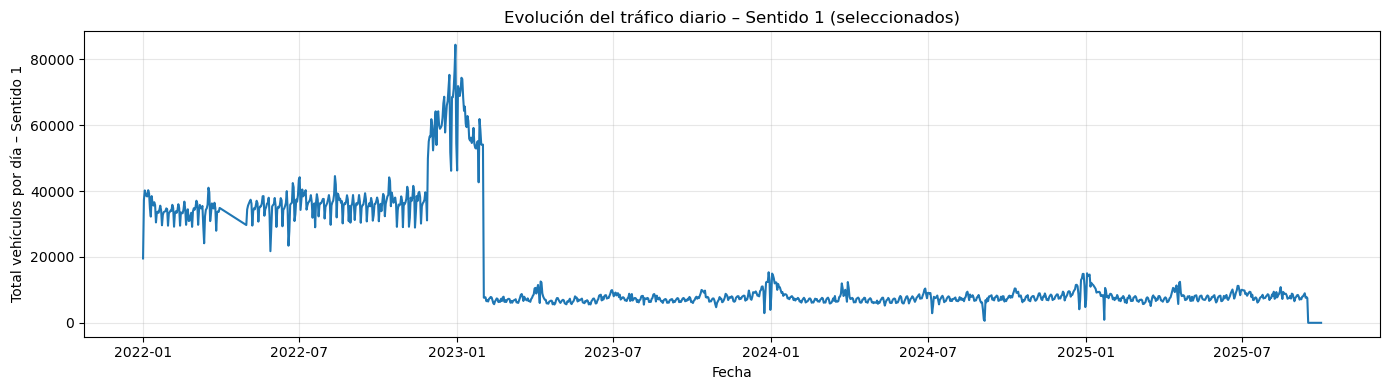

In [21]:
plt.figure(figsize=(14, 4))
plt.plot(daily_dir['fecha'], daily_dir['total_sentido_1'])
plt.title("Evolución del tráfico diario – Sentido 1 (seleccionados)")
plt.xlabel("Fecha")
plt.ylabel("Total vehículos por día – Sentido 1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


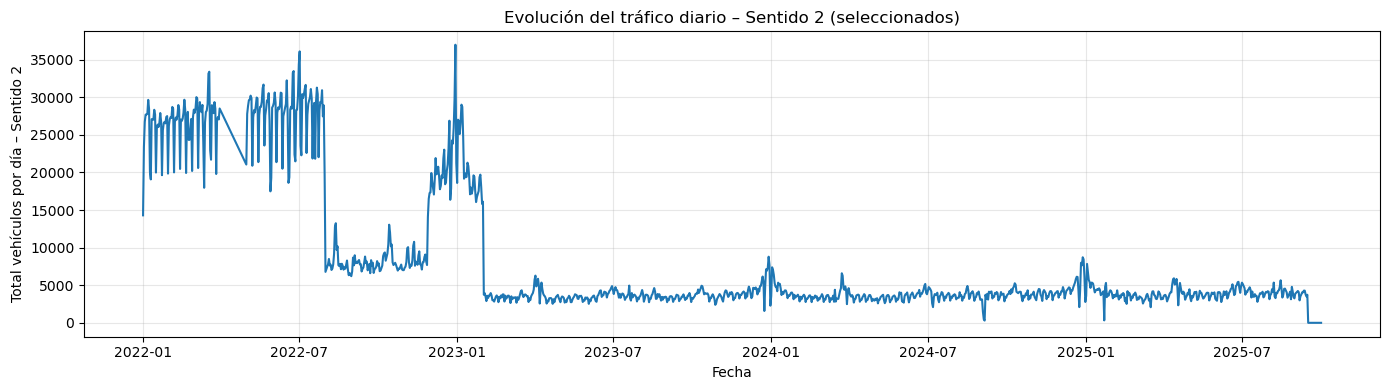

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(daily_dir['fecha'], daily_dir['total_sentido_2'])
plt.title("Evolución del tráfico diario – Sentido 2 (seleccionados)")
plt.xlabel("Fecha")
plt.ylabel("Total vehículos por día – Sentido 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

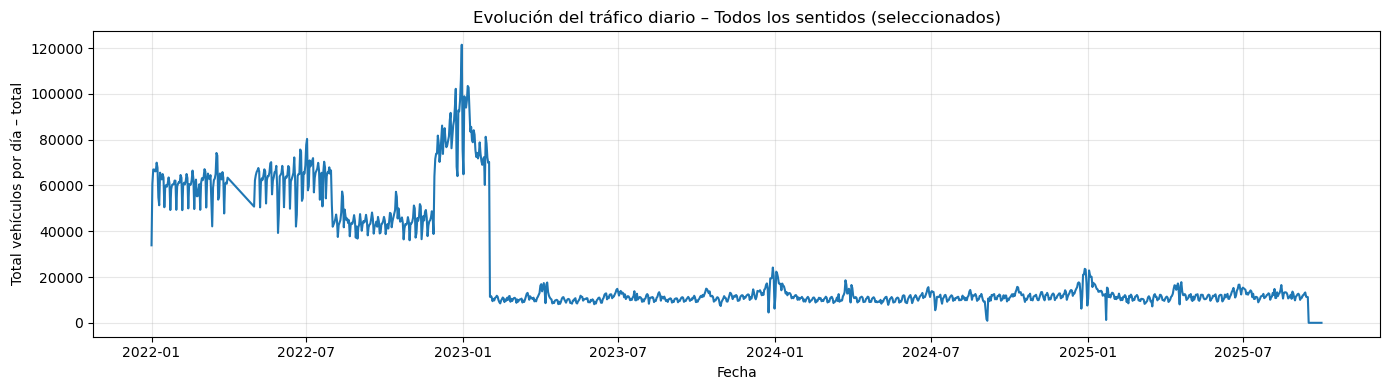

In [23]:
plt.figure(figsize=(14, 4))
plt.plot(daily_dir['fecha'], daily_dir['total_todos_sentidos'])
plt.title("Evolución del tráfico diario – Todos los sentidos (seleccionados)")
plt.xlabel("Fecha")
plt.ylabel("Total vehículos por día – total")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

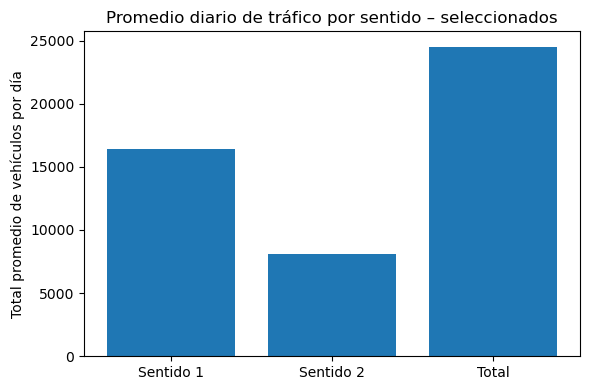

In [24]:
# Promedio diario por sentido sobre todo el período
avg_s1 = daily_dir['total_sentido_1'].mean()
avg_s2 = daily_dir['total_sentido_2'].mean()
avg_total = daily_dir['total_todos_sentidos'].mean()

sentidos = ['Sentido 1', 'Sentido 2', 'Total']
valores = [avg_s1, avg_s2, avg_total]

plt.figure(figsize=(6, 4))
plt.bar(sentidos, valores)
plt.title("Promedio diario de tráfico por sentido – seleccionados")
plt.ylabel("Total promedio de vehículos por día")
plt.tight_layout()
plt.show()

In [25]:
# -----------------------------
# 1. Load data
# -----------------------------
df = pd.read_csv("trafico_limpio.csv")

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])

# -----------------------------
# 2. Filter to target peajes
# -----------------------------
peajes_target = [
    "PTO. TRIUNFO",
    "SACHICA",
    "CASABLANCA",
    "PEAJE TUNEL LA LINEA QUINDIO",
    "CERRITOS II",
    "PEAJE TUNEL LA LINEA TOLIMA",
    "BICENTENARIO",
    "LA PARADA",
]

df = df[df['peaje'].isin(peajes_target)].copy()

# -----------------------------
# 3. Direction totals
# -----------------------------
df['sentido_1'] = df['sentido_1'].fillna(0)
df['sentido_2'] = df['sentido_2'].fillna(0)

df['total_s1'] = df['sentido_1']
df['total_s2'] = df['sentido_2']
df['total_all'] = df['total_s1'] + df['total_s2']

# Drop rows without TRM if any
df = df.dropna(subset=['trm_dolar'])

df.head()

,fecha,peaje,sentido_1,sentido_2,total,tipo_dia,trm_dolar,total_s1,total_s2,total_all
55,2022-01-04,CASABLANCA,12858,5876,18734,entre_semana,4082.75,12858,5876,18734
59,2022-01-04,LA PARADA,17127,17127,34254,entre_semana,4082.75,17127,17127,34254
66,2022-01-04,PTO. TRIUNFO,9294,4701,13995,entre_semana,4082.75,9294,4701,13995
73,2022-01-05,CASABLANCA,12256,6017,18273,entre_semana,4084.11,12256,6017,18273
77,2022-01-05,LA PARADA,17180,17180,34360,entre_semana,4084.11,17180,17180,34360


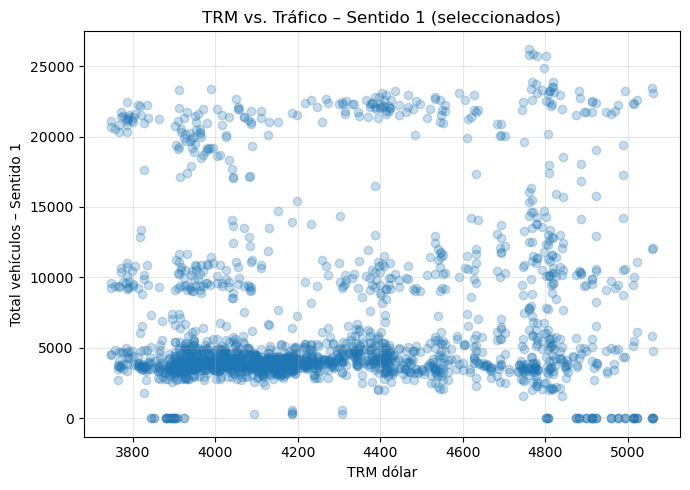

In [26]:
plt.figure(figsize=(7,5))
plt.scatter(df['trm_dolar'], df['total_s1'], alpha=0.25)
plt.title("TRM vs. Tráfico – Sentido 1 (seleccionados)")
plt.xlabel("TRM dólar")
plt.ylabel("Total vehículos – Sentido 1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


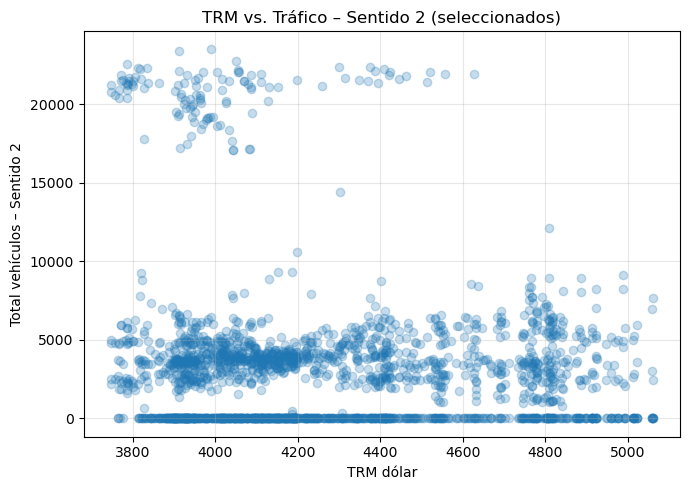

In [27]:
plt.figure(figsize=(7,5))
plt.scatter(df['trm_dolar'], df['total_s2'], alpha=0.25)
plt.title("TRM vs. Tráfico – Sentido 2 (seleccionados)")
plt.xlabel("TRM dólar")
plt.ylabel("Total vehículos – Sentido 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

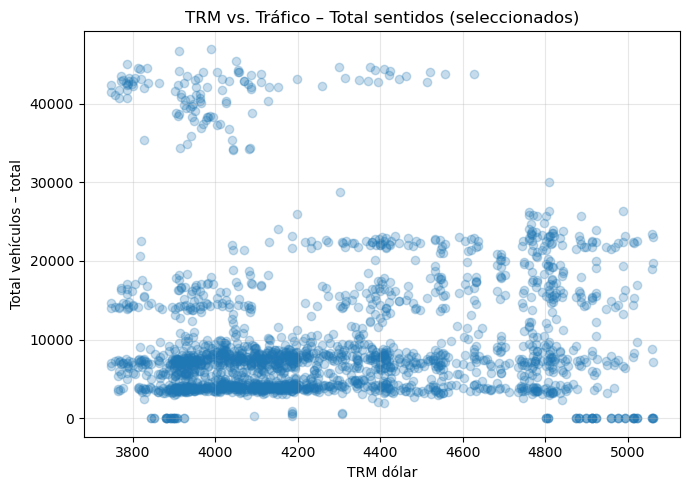

In [28]:
plt.figure(figsize=(7,5))
plt.scatter(df['trm_dolar'], df['total_all'], alpha=0.25)
plt.title("TRM vs. Tráfico – Total sentidos (seleccionados)")
plt.xlabel("TRM dólar")
plt.ylabel("Total vehículos – total")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
tipo_stats = (
    df.groupby('tipo_dia')[['total_s1','total_s2','total_all']]
      .mean()
      .reset_index()
)
tipo_stats

,tipo_dia,total_s1,total_s2,total_all
0,entre_semana,6855.721321,3437.096697,10292.818018
1,festivo,5490.225806,2866.161290,8356.387097
2,fin_de_semana,6658.515766,3325.617117,9984.132883


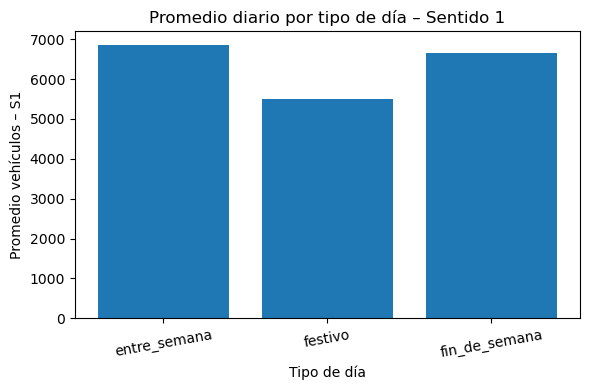

In [30]:
plt.figure(figsize=(6,4))
plt.bar(tipo_stats['tipo_dia'], tipo_stats['total_s1'])
plt.title("Promedio diario por tipo de día – Sentido 1")
plt.xlabel("Tipo de día")
plt.ylabel("Promedio vehículos – S1")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

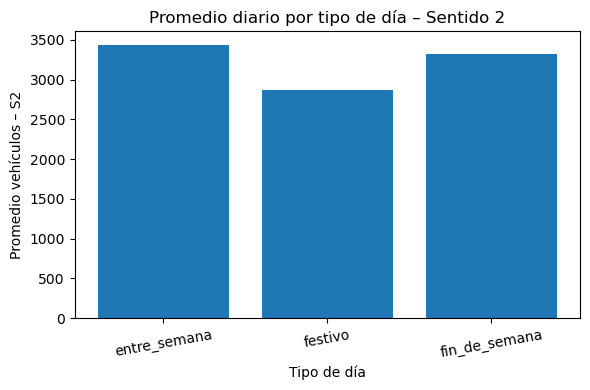

In [31]:
plt.figure(figsize=(6,4))
plt.bar(tipo_stats['tipo_dia'], tipo_stats['total_s2'])
plt.title("Promedio diario por tipo de día – Sentido 2")
plt.xlabel("Tipo de día")
plt.ylabel("Promedio vehículos – S2")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

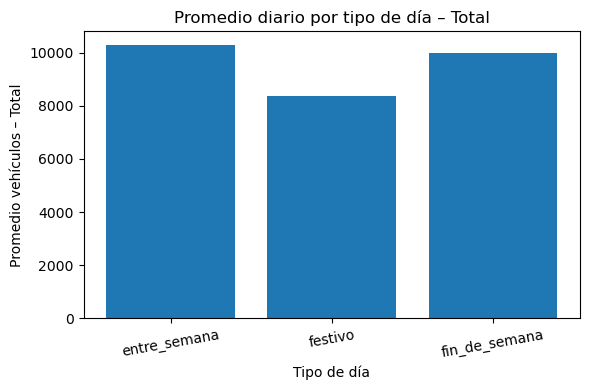

In [32]:
plt.figure(figsize=(6,4))
plt.bar(tipo_stats['tipo_dia'], tipo_stats['total_all'])
plt.title("Promedio diario por tipo de día – Total")
plt.xlabel("Tipo de día")
plt.ylabel("Promedio vehículos – Total")
plt.xticks(rotation=10)
plt.tight_layout()
plt.show()

In [34]:
# 1. Load data
df = pd.read_csv("trafico_limpio.csv")

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha'])

# 2. Filter to target peajes
peajes_target = [
    "PTO. TRIUNFO",
    "SACHICA",
    "CASABLANCA",
    "PEAJE TUNEL LA LINEA QUINDIO",
    "CERRITOS II",
    "PEAJE TUNEL LA LINEA TOLIMA",
    "BICENTENARIO",
    "LA PARADA",
]

df = df[df['peaje'].isin(peajes_target)].copy()

# 3. Make sure direction columns exist and are numeric
for col in ['sentido_1', 'sentido_2']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# 4. Aggregate to daily level across the selected peajes
#    (TRM should be the same per day; we take the mean just in case)
daily = (
    df.groupby('fecha', as_index=False)
      .agg(
          trm_dolar=('trm_dolar', 'mean'),
          vol_s1=('sentido_1', 'sum'),
          vol_s2=('sentido_2', 'sum')
      )
)

daily['vol_total'] = daily['vol_s1'] + daily['vol_s2']

daily.head()

,fecha,trm_dolar,vol_s1,vol_s2,vol_total
0,2022-01-01,NaN,19554,14301,33855
1,2022-01-02,NaN,37329,23391,60720
2,2022-01-03,NaN,40221,26742,66963
3,2022-01-04,4082.75,39279,27704,66983
4,2022-01-05,4084.11,38477,27722,66199


In [35]:
from scipy.stats import pearsonr, spearmanr

def corr_report(x, y, name_x="TRM", name_y="Volumen"):
    # Drop any missing values pairwise
    mask = (~pd.isna(x)) & (~pd.isna(y))
    x_clean = x[mask]
    y_clean = y[mask]
    
    pear_r, pear_p = pearsonr(x_clean, y_clean)
    spear_r, spear_p = spearmanr(x_clean, y_clean)
    
    print(f"=== {name_x} vs {name_y} ===")
    print(f"Pearson r  : {pear_r: .4f}  (p={pear_p: .4g})")
    print(f"Spearman r : {spear_r: .4f}  (p={spear_p: .4g})")
    print()

# Sentido 1
corr_report(daily['trm_dolar'], daily['vol_s1'],
            name_x="TRM", name_y="Volumen Sentido 1")

# Sentido 2
corr_report(daily['trm_dolar'], daily['vol_s2'],
            name_x="TRM", name_y="Volumen Sentido 2")

# Total sentidos
corr_report(daily['trm_dolar'], daily['vol_total'],
            name_x="TRM", name_y="Volumen Total")

=== TRM vs Volumen Sentido 1 ===
Pearson r  :  0.3553  (p= 3.17e-27)
Spearman r :  0.2101  (p= 4.043e-10)

=== TRM vs Volumen Sentido 2 ===
Pearson r  : -0.0210  (p= 0.536)
Spearman r :  0.0984  (p= 0.003704)

=== TRM vs Volumen Total ===
Pearson r  :  0.2295  (p= 7.787e-12)
Spearman r :  0.1455  (p= 1.692e-05)



In [36]:
from sklearn.linear_model import LinearRegression

def simple_regression(x, y, label):
    mask = (~pd.isna(x)) & (~pd.isna(y))
    X = x[mask].values.reshape(-1, 1)
    y_vec = y[mask].values

    model = LinearRegression()
    model.fit(X, y_vec)

    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y_vec)

    print(f"=== Regresión lineal: TRM → {label} ===")
    print(f"Volumen ≈ {intercept:,.2f} + {slope:,.4f} * TRM")
    print(f"R² = {r2: .4f}")
    print()

# Sentido 1
simple_regression(daily['trm_dolar'], daily['vol_s1'], "Volumen Sentido 1")

# Sentido 2
simple_regression(daily['trm_dolar'], daily['vol_s2'], "Volumen Sentido 2")

# Total
simple_regression(daily['trm_dolar'], daily['vol_total'], "Volumen Total")


=== Regresión lineal: TRM → Volumen Sentido 1 ===
Volumen ≈ -63,141.92 + 18.9888 * TRM
R² =  0.1262

=== Regresión lineal: TRM → Volumen Sentido 2 ===
Volumen ≈ 11,105.19 + -0.6438 * TRM
R² =  0.0004

=== Regresión lineal: TRM → Volumen Total ===
Volumen ≈ -52,036.73 + 18.3450 * TRM
R² =  0.0527



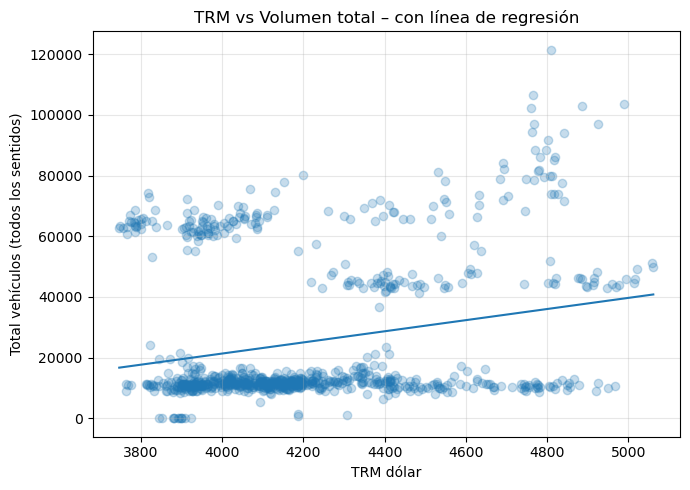

In [37]:
# Use daily data
mask = (~pd.isna(daily['trm_dolar'])) & (~pd.isna(daily['vol_total']))
X = daily.loc[mask, 'trm_dolar'].values.reshape(-1, 1)
y = daily.loc[mask, 'vol_total'].values

model = LinearRegression()
model.fit(X, y)

# Line for plotting
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)

plt.figure(figsize=(7,5))
plt.scatter(X, y, alpha=0.25)
plt.plot(x_line, y_line)
plt.title("TRM vs Volumen total – con línea de regresión")
plt.xlabel("TRM dólar")
plt.ylabel("Total vehículos (todos los sentidos)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. [20%] Construcción y evaluación del modelo

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump

# Ruta al CSV ya procesado (trafico_limpio.csv)
CSV_PATH = "/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/trafico_limpio.csv"  # cambia en la ruta

df = pd.read_csv(CSV_PATH)

# Asegurar tipo fecha
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

print(df.shape)
df.head()

(38859, 7)


,fecha,peaje,sentido_1,sentido_2,total,tipo_dia,trm_dolar
0,2022-01-01,AGUAS NEGRASdef,4596,2810,7406,festivo,NaN
1,2022-01-01,CASABLANCA,7845,4248,12093,festivo,NaN
2,2022-01-01,COCORNA (EL SANTUARIO),5649,3034,8683,festivo,NaN
3,2022-01-01,CURITÍ,4016,1988,6004,festivo,NaN
4,2022-01-01,LA GOMEZ,3761,2342,6103,festivo,NaN


## Se filtra para usar las estaciones objetivo

In [40]:
# Lista de peajes target
peajes_target = [
    "PTO. TRIUNFO",
    "SACHICA",
    "CASABLANCA",
    "PEAJE TUNEL LA LINEA QUINDIO",
    "CERRITOS II",
    "PEAJE TUNEL LA LINEA TOLIMA",
    "BICENTENARIO",
    "LA PARADA",
]

# Filtrar solo estos peajes
df = df[df['peaje'].isin(peajes_target)].copy()

# Ordenar cronológicamente por peaje
df = df.sort_values(['peaje', 'fecha']).reset_index(drop=True)

df['peaje'].unique(), df.shape

(array(['BICENTENARIO', 'CASABLANCA', 'CERRITOS II', 'LA PARADA',
        'PEAJE TUNEL LA LINEA QUINDIO', 'PEAJE TUNEL LA LINEA TOLIMA',
        'PTO. TRIUNFO', 'SACHICA'], dtype=object),
 (3322, 7))

## Se recalcula el tipo de dia.

In [41]:
# Recalcular tipo de día usando festivos Colombia
years = range(df['fecha'].dt.year.min(), df['fecha'].dt.year.max() + 2)
co_holidays = holidays.country_holidays('CO', years=years)

def clasificar_dia(fecha):
    d = fecha.date()
    if d in co_holidays:
        return "festivo"
    elif fecha.weekday() >= 5:
        return "fin_de_semana"
    else:
        return "entre_semana"

df['tipo_dia'] = df['fecha'].apply(clasificar_dia)

# Variables de calendario
df['year'] = df['fecha'].dt.year
df['month'] = df['fecha'].dt.month
df['day'] = df['fecha'].dt.day
df['dayofweek'] = df['fecha'].dt.dayofweek
df['dayofyear'] = df['fecha'].dt.dayofyear

# Representaciones cíclicas
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# One-hot de tipo_dia
df = pd.get_dummies(df, columns=['tipo_dia'], drop_first=False)

df.head()

,fecha,peaje,sentido_1,sentido_2,total,trm_dolar,year,month,day,dayofweek,dayofyear,dow_sin,dow_cos,month_sin,month_cos,tipo_dia_entre_semana,tipo_dia_festivo,tipo_dia_fin_de_semana
0,2022-11-01,BICENTENARIO,0,0,0,4898.74,2022,11,1,1,305,0.781831,0.623490,-0.866025,0.5,True,False,False
1,2022-11-02,BICENTENARIO,0,0,0,4975.58,2022,11,2,2,306,0.974928,-0.222521,-0.866025,0.5,True,False,False
2,2022-11-03,BICENTENARIO,0,0,0,5015.84,2022,11,3,3,307,0.433884,-0.900969,-0.866025,0.5,True,False,False
3,2022-11-04,BICENTENARIO,0,0,0,5058.02,2022,11,4,4,308,-0.433884,-0.900969,-0.866025,0.5,True,False,False
4,2022-11-05,BICENTENARIO,0,0,0,5061.21,2022,11,5,5,309,-0.974928,-0.222521,-0.866025,0.5,False,False,True


## Funciones aplicadas para el tratamiento de series de tiempo

- **Lags:** permiten capturar dependencias temporales y tendencias semanales en la demanda vehicular.
- **Trim zeros:** reduce ruidos eliminando tramos de ceros al inicio o final de la serie que distorsionan los patrones reales del modelo.
- **Time series split:** realiza una división cronológica adecuada entre entrenamiento, validación y prueba, evitando *data leakage* propio de las series temporales.
- **Slugify:** normaliza los nombres de los peajes para generar identificadores seguros y consistentes en archivos y modelos.


In [42]:
def add_lag_and_rolling_features(
    df,
    group_col='peaje',
    target_cols=('sentido_1', 'sentido_2'),
    lags=(1, 3, 7, 14, 21, 28),
    rolling_windows=(3, 7, 14, 28)
):
    df = df.copy()
    df = df.sort_values([group_col, 'fecha'])

    for target in target_cols:
        if target not in df.columns:
            continue

        # Lags
        for lag in lags:
            df[f'{target}_lag_{lag}'] = df.groupby(group_col)[target].shift(lag)

        # Medias móviles (shift 1 para no usar el día actual)
        for win in rolling_windows:
            df[f'{target}_rollmean_{win}'] = (
                df.groupby(group_col)[target]
                  .shift(1)
                  .rolling(win)
                  .mean()
            )
    return df


def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    # evitar división por cero
    mask = denom != 0
    return np.mean(diff[mask] / denom[mask]) * 100 if np.any(mask) else np.nan


def mase(y_true, y_pred, y_train, seasonality=7):
    """
    y_true, y_pred: parte a evaluar (val o test)
    y_train: serie de entrenamiento (para el denominador)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_train = np.array(y_train)

    if len(y_train) <= seasonality:
        return np.nan

    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    denom = np.mean(np.abs(naive_forecast))
    if denom == 0:
        return np.nan

    return np.mean(np.abs(y_true - y_pred)) / denom


def trim_zeros_begin_end(df_peaje, col='total'):
    """
    Recorta filas al inicio y al final donde col == 0 para ese peaje.
    Mantiene ceros internos si los hubiera.
    """
    arr = df_peaje[col].values
    non_zero_idx = np.where(arr != 0)[0]
    if len(non_zero_idx) == 0:
        return df_peaje.iloc[0:0].copy()  # vacío
    start_i = non_zero_idx[0]
    end_i = non_zero_idx[-1]
    return df_peaje.iloc[start_i:end_i+1].copy()


def time_series_split_train_val_test(df_peaje, test_days=30, val_days=90):
    """
    Split cronológico:
    - test: últimos `test_days`
    - validation: `val_days` anteriores a test (o menos si no hay tantos datos)
    - train: el resto.
    Si no hay suficientes datos, se reduce validation.
    """
    df_peaje = df_peaje.sort_values('fecha').reset_index(drop=True)
    n = len(df_peaje)
    if n <= test_days + 10:
        # muy pocos datos, reducimos test y val proporcionalmente
        test_days = min(10, n // 3)
        val_days = min(30, max(0, n - test_days - 10))

    test_size = min(test_days, n)
    val_size = min(val_days, max(0, n - test_size))

    test_start = n - test_size
    val_start = max(0, n - test_size - val_size)

    train = df_peaje.iloc[:val_start].copy()
    val = df_peaje.iloc[val_start:test_start].copy()
    test = df_peaje.iloc[test_start:].copy()

    return train, val, test


import re
import unicodedata

def slugify(s):
    s = str(s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    s = re.sub(r'[^a-zA-Z0-9]+', '_', s)
    s = s.strip('_').lower()
    return s

In [43]:
# Crear lags y medias móviles por peaje
df_feat = add_lag_and_rolling_features(
    df,
    group_col='peaje',
    target_cols=('sentido_1', 'sentido_2'),
    lags=(1, 3, 7, 14, 21, 28),
    rolling_windows=(3, 7, 14, 28)
)

# Después de crear lags/rolling, habrá NaNs al inicio de cada serie.
# Los eliminamos por peaje para evitar problemas.
def drop_na_per_peaje(df_in, group_col='peaje'):
    dfs = []
    for g, dfg in df_in.groupby(group_col):
        dfg = dfg.dropna().reset_index(drop=True)
        dfs.append(dfg)
    return pd.concat(dfs, axis=0).reset_index(drop=True)

df_feat = drop_na_per_peaje(df_feat, group_col='peaje')
df_feat.head()

,fecha,peaje,sentido_1,sentido_2,total,trm_dolar,year,month,day,dayofweek,...,sentido_2_lag_1,sentido_2_lag_3,sentido_2_lag_7,sentido_2_lag_14,sentido_2_lag_21,sentido_2_lag_28,sentido_2_rollmean_3,sentido_2_rollmean_7,sentido_2_rollmean_14,sentido_2_rollmean_28
0,2022-11-29,BICENTENARIO,1560,813,2373,4840.60,2022,11,29,1,...,657.0,0.0,0.0,0.0,0.0,0.0,219.0,93.857143,46.928571,23.464286
1,2022-11-30,BICENTENARIO,1997,1005,3002,4809.51,2022,11,30,2,...,813.0,0.0,0.0,0.0,0.0,0.0,490.0,210.000000,105.000000,52.500000
2,2022-12-01,BICENTENARIO,2092,1083,3175,4815.59,2022,12,1,3,...,1005.0,657.0,0.0,0.0,0.0,0.0,825.0,353.571429,176.785714,88.392857
3,2022-12-02,BICENTENARIO,2265,1218,3483,4779.06,2022,12,2,4,...,1083.0,813.0,0.0,0.0,0.0,0.0,967.0,508.285714,254.142857,127.071429
4,2022-12-03,BICENTENARIO,2041,1095,3136,4767.19,2022,12,3,5,...,1218.0,1005.0,0.0,0.0,0.0,0.0,1102.0,682.285714,341.142857,170.571429


## Entrenamiento con busqueda de hiperparametros y metricas 

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Función RMSE compatible con cualquier versión de sklearn
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def train_xgb_with_tuning(df_peaje, target_col, use_gpu=True):
    """
    Entrena XGBoost para un peaje y un sentido específico:
    - Recorta ceros al inicio/fin según 'total'.
    - Split train/val/test cronológico.
    - Búsqueda de hiperparámetros sobre un conjunto de candidatos.
    - Compatible con versiones antiguas de xgboost y sklearn.
    """
    # Recorte de ceros inicio/fin según total
    df_peaje = trim_zeros_begin_end(df_peaje, col='total')
    df_peaje = df_peaje.sort_values('fecha').reset_index(drop=True)

    # Si no hay variación
    if target_col not in df_peaje.columns or df_peaje[target_col].nunique() <= 1:
        print(f"[{df_peaje['peaje'].iloc[0]} - {target_col}] Sin variación suficiente, se omite.")
        return None

    # Split temporal
    train_df, val_df, test_df = time_series_split_train_val_test(
        df_peaje, test_days=30, val_days=90
    )

    # Features: excluir columnas que causan leakage
    exclude_cols = ['fecha', 'peaje', 'sentido_1', 'sentido_2', 'total']
    feature_cols = [c for c in df_peaje.columns if c not in exclude_cols]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val   = val_df[feature_cols]
    y_val   = val_df[target_col]
    X_test  = test_df[feature_cols]
    y_test  = test_df[target_col]

    # Tu versión no soporta GPU → usar siempre 'hist'
    tree_method = "hist"

    # Espacio de hiperparámetros
    param_grid = [
        {"max_depth": 3, "learning_rate": 0.05, "n_estimators": 600,
         "subsample": 0.9, "colsample_bytree": 0.9, "min_child_weight": 1, "gamma": 0.0},

        {"max_depth": 4, "learning_rate": 0.05, "n_estimators": 800,
         "subsample": 0.9, "colsample_bytree": 0.9, "min_child_weight": 5, "gamma": 0.0},

        {"max_depth": 5, "learning_rate": 0.03, "n_estimators": 1000,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 3, "gamma": 0.1},

        {"max_depth": 6, "learning_rate": 0.03, "n_estimators": 1200,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 5, "gamma": 0.1},

        {"max_depth": 4, "learning_rate": 0.1, "n_estimators": 500,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 1, "gamma": 0.0},
    ]

    best_model = None
    best_rmse_val = np.inf
    best_params = None

    # BÚSQUEDA MANUAL DE HIPERPARÁMETROS (SIN early stopping)
    for params in param_grid:
        model = XGBRegressor(
            objective="reg:squarederror",
            tree_method=tree_method,
            random_state=42,
            **params
        )

        model.fit(X_train, y_train)  # sin eval_set, sin callbacks

        # Métrica VALIDACIÓN
        y_val_pred = model.predict(X_val)
        rmse_val = rmse(y_val, y_val_pred)

        if rmse_val < best_rmse_val:
            best_rmse_val = rmse_val
            best_model = model
            best_params = params

    print(f"Mejores hiperparámetros para {df_peaje['peaje'].iloc[0]} - {target_col}: {best_params}")
    print(f"RMSE validación = {best_rmse_val:.2f}")

    # Usamos el mejor modelo encontrado
    final_model = best_model

    # Predicciones en TRAIN / VAL / TEST
    y_train_pred = final_model.predict(X_train)
    y_val_pred   = final_model.predict(X_val)
    y_test_pred  = final_model.predict(X_test)

    # Métricas
    rmse_train = rmse(y_train, y_train_pred)
    rmse_val   = rmse(y_val, y_val_pred)
    rmse_test  = rmse(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val   = mean_absolute_error(y_val, y_val_pred)
    mae_test  = mean_absolute_error(y_test, y_test_pred)

    smape_val = smape(y_val, y_val_pred)
    smape_test = smape(y_test, y_test_pred)

    y_trainval = pd.concat([y_train, y_val]).values
    mase_val = mase(y_val, y_val_pred, y_trainval, seasonality=7)
    mase_test = mase(y_test, y_test_pred, y_trainval, seasonality=7)

    metrics = {
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "rmse_val": rmse_val,
        "mae_val": mae_val,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "smape_val": smape_val,
        "smape_test": smape_test,
        "mase_val": mase_val,
        "mase_test": mase_test,
        "best_params": best_params,
    }

    splits = {
        "train": train_df,
        "val": val_df,
        "test": test_df,
        "y_train_pred": y_train_pred,
        "y_val_pred": y_val_pred,
        "y_test_pred": y_test_pred,
        "feature_cols": feature_cols,
    }

    return final_model, metrics, splits

## Se pronostica 30 dias y se construye el dataframe (si se desea modificar "horizon=30" a la cantidad de dias que requiera)

In [45]:
def get_tipo_dia_from_date(fecha):
    d = fecha.date()
    if d in co_holidays:
        return "festivo"
    elif fecha.weekday() >= 5:
        return "fin_de_semana"
    else:
        return "entre_semana"


def build_features_for_future_row(last_known_row, new_date):
    """
    Construye features de calendario y tipo_dia dummies a partir de la última fila conocida.
    TRM (u otras exógenas) se mantienen igual al último valor disponible.
    """
    row = last_known_row.copy()
    row['fecha'] = new_date
    row['year'] = new_date.year
    row['month'] = new_date.month
    row['day'] = new_date.day
    row['dayofweek'] = new_date.dayofweek
    row['dayofyear'] = new_date.timetuple().tm_yday
    row['dow_sin'] = np.sin(2 * np.pi * row['dayofweek'] / 7)
    row['dow_cos'] = np.cos(2 * np.pi * row['dayofweek'] / 7)
    row['month_sin'] = np.sin(2 * np.pi * (row['month'] - 1) / 12)
    row['month_cos'] = np.cos(2 * np.pi * (row['month'] - 1) / 12)

    tipo = get_tipo_dia_from_date(new_date)
    for col in ['tipo_dia_entre_semana', 'tipo_dia_fin_de_semana', 'tipo_dia_festivo']:
        if col not in row:
            row[col] = 0
    row['tipo_dia_entre_semana'] = 1 if tipo == "entre_semana" else 0
    row['tipo_dia_fin_de_semana'] = 1 if tipo == "fin_de_semana" else 0
    row['tipo_dia_festivo'] = 1 if tipo == "festivo" else 0

    # TRM y otras exógenas: mantenemos el último valor
    # (ya vienen en last_known_row, no las tocamos)

    return row


def forecast_future_days(df_peaje_full, model, target_col, feature_cols, horizon=30):
    """
    Pronostica 'horizon' días hacia adelante de forma recursiva
    usando el modelo y recalculando lags/rolling con cada nueva predicción.
    """
    history = df_peaje_full.sort_values('fecha').copy()
    history = history.reset_index(drop=True)

    future_rows = []

    last_date = history['fecha'].max()
    for step in range(horizon):
        new_date = last_date + timedelta(days=1)
        last_date = new_date

        # Tomamos la última fila de history como base para exógenas
        base_row = history.iloc[-1].copy()
        new_row = build_features_for_future_row(base_row, new_date)

        # Recalcular lags y rolling para el target específico
        # 1) añadimos temporalmente la nueva fila sin target
        temp = pd.concat([history, pd.DataFrame([new_row])], axis=0).reset_index(drop=True)

        # 2) volvemos a calcular lags/rolling SOLO para el peaje en cuestión
        temp = add_lag_and_rolling_features(
            temp,
            group_col='peaje',
            target_cols=(target_col,),
            lags=(1, 3, 7, 14, 21, 28),
            rolling_windows=(3, 7, 14, 28)
        )

        new_row_full = temp.iloc[-1].copy()

        # Si aún hay NaNs en lags/rolling (al principio), los podemos rellenar con 0
        new_row_full = new_row_full.fillna(0)

        X_new = new_row_full[feature_cols].values.reshape(1, -1)
        y_new_pred = model.predict(X_new)[0]

        new_row_full[target_col] = y_new_pred

        history = temp.copy()
        future_rows.append(new_row_full)

    future_df = pd.DataFrame(future_rows)
    return future_df


def build_full_results_df(df_peaje, target_col, splits, future_df, metrics, model_name):
    """
    Construye un DataFrame unificado con:
    - train/val/test/future
    - y_real, y_pred
    - métricas
    """
    train_df = splits["train"].copy()
    val_df = splits["val"].copy()
    test_df = splits["test"].copy()

    y_train_pred = splits["y_train_pred"]
    y_val_pred = splits["y_val_pred"]
    y_test_pred = splits["y_test_pred"]

    train_df['set'] = 'train'
    val_df['set'] = 'val'
    test_df['set'] = 'test'

    train_df['y_real'] = train_df[target_col]
    val_df['y_real'] = val_df[target_col]
    test_df['y_real'] = test_df[target_col]

    train_df['y_pred'] = y_train_pred
    val_df['y_pred'] = y_val_pred
    test_df['y_pred'] = y_test_pred

    # Future: solo predicciones, no hay y_real
    future_df = future_df.copy()
    future_df['set'] = 'future'
    future_df['y_real'] = np.nan
    future_df['y_pred'] = future_df[target_col]

    full = pd.concat([train_df, val_df, test_df, future_df], axis=0, ignore_index=True)
    full = full.sort_values('fecha').reset_index(drop=True)

    full['modelo'] = model_name
    full['target'] = target_col

    # Añadimos métricas como columnas (repetidas, pero simples de consumir luego)
    for k, v in metrics.items():
        full[k] = v

    return full


def plot_results(full_df, peaje, target_col):
    """
    Grafica:
    - Serie completa real (train+val+test)
    - Predicciones en test (últimos 30 días reales)
    - Predicciones en los 30 días futuros
    """
    full_df = full_df.sort_values('fecha')

    fig, ax = plt.subplots(figsize=(14, 5))

    # Serie real
    real_mask = full_df['set'].isin(['train', 'val', 'test'])
    ax.plot(full_df.loc[real_mask, 'fecha'],
            full_df.loc[real_mask, 'y_real'],
            label='Real')

    # Predicciones test
    test_mask = full_df['set'] == 'test'
    ax.plot(full_df.loc[test_mask, 'fecha'],
            full_df.loc[test_mask, 'y_pred'],
            linestyle='--',
            label='Predicción test')

    # Predicciones futuro
    future_mask = full_df['set'] == 'future'
    ax.plot(full_df.loc[future_mask, 'fecha'],
            full_df.loc[future_mask, 'y_pred'],
            linestyle=':',
            label='Predicción 30 días futuros')

    ax.set_title(f"{peaje} - {target_col}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Tráfico")
    ax.legend()
    plt.tight_layout()
    plt.show()

## Se entrenan los modelos

Peajes a modelar: ['BICENTENARIO' 'CASABLANCA' 'CERRITOS II' 'LA PARADA'
 'PEAJE TUNEL LA LINEA QUINDIO' 'PEAJE TUNEL LA LINEA TOLIMA'
 'PTO. TRIUNFO' 'SACHICA']

===== Entrenando modelo para BICENTENARIO - sentido_1 =====
Mejores hiperparámetros para BICENTENARIO - sentido_1: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 1535.37
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_bicentenario_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_bicentenario_sentido_1.csv


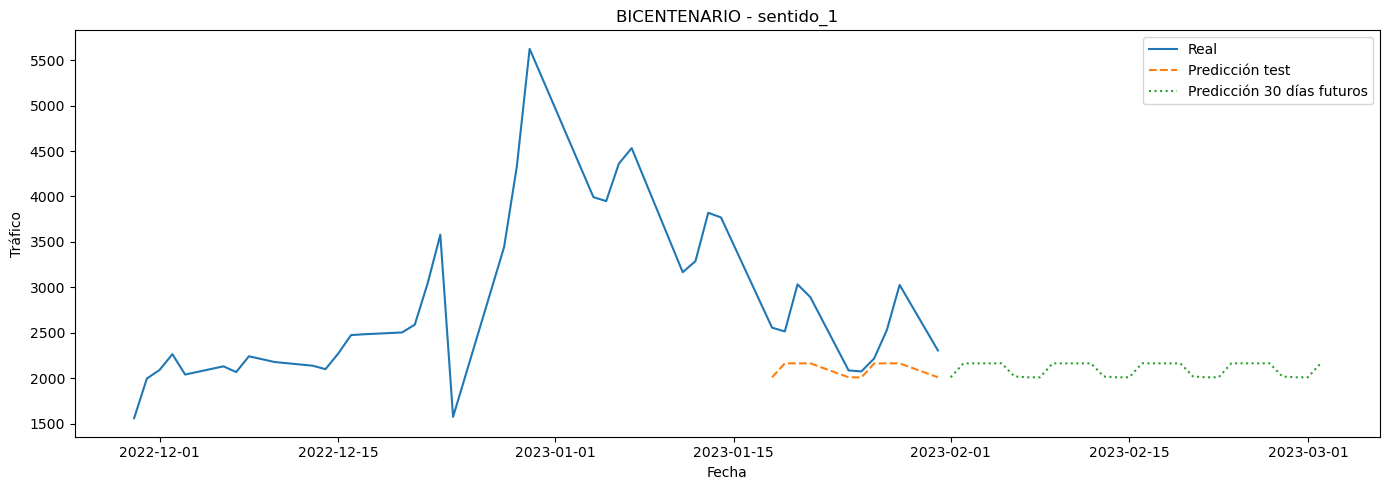


===== Entrenando modelo para BICENTENARIO - sentido_2 =====
Mejores hiperparámetros para BICENTENARIO - sentido_2: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 944.78
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_bicentenario_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_bicentenario_sentido_2.csv


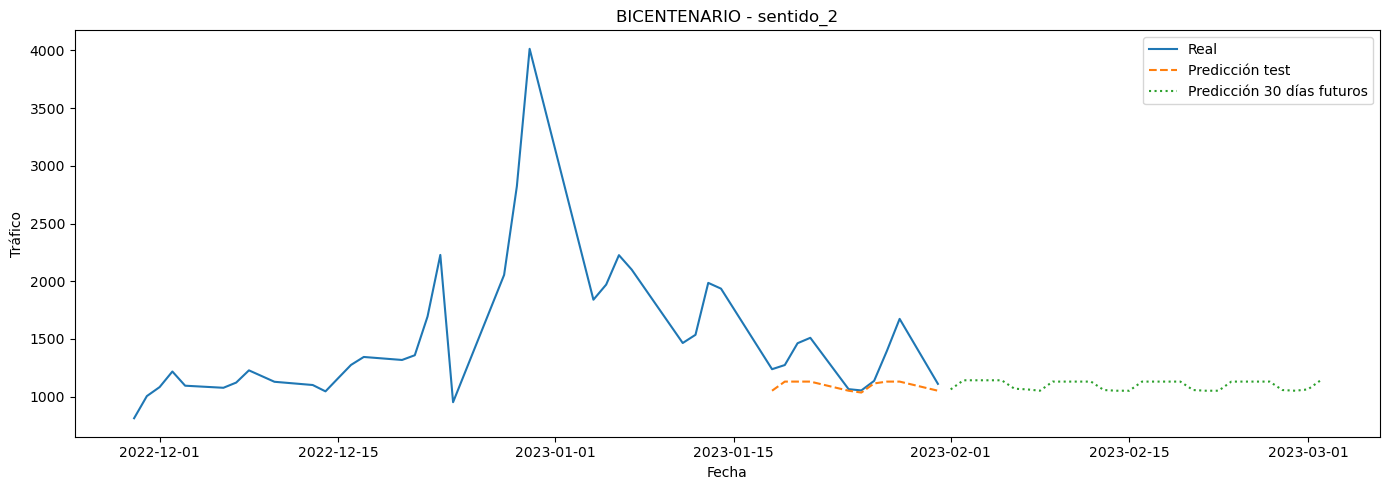


===== Entrenando modelo para CASABLANCA - sentido_1 =====
Mejores hiperparámetros para CASABLANCA - sentido_1: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 840.04
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_casablanca_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_casablanca_sentido_1.csv


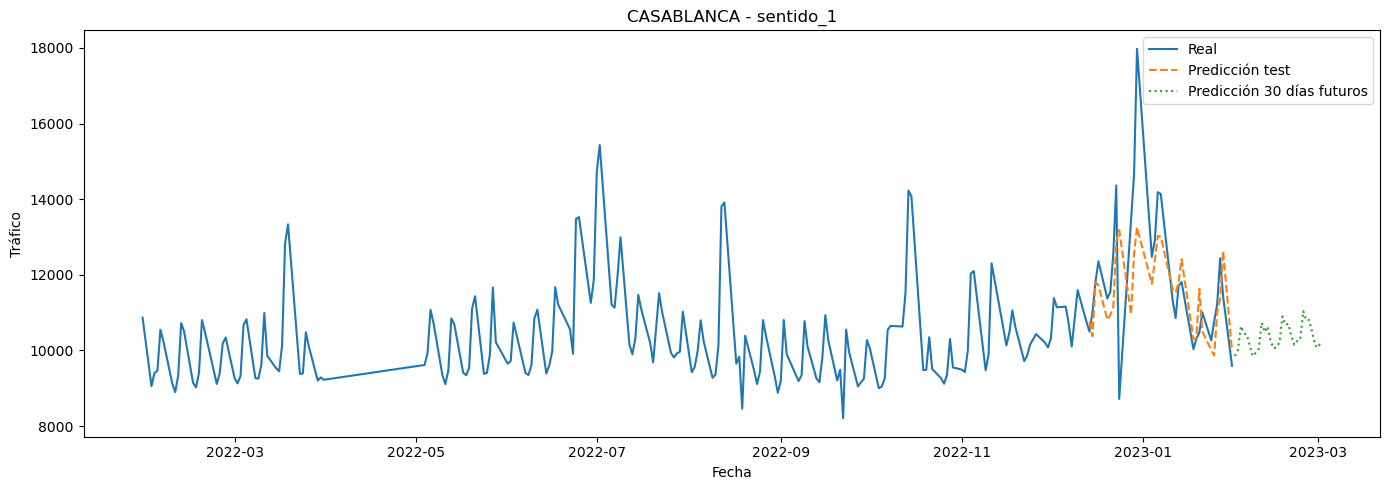


===== Entrenando modelo para CASABLANCA - sentido_2 =====
Mejores hiperparámetros para CASABLANCA - sentido_2: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 726.07
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_casablanca_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_casablanca_sentido_2.csv


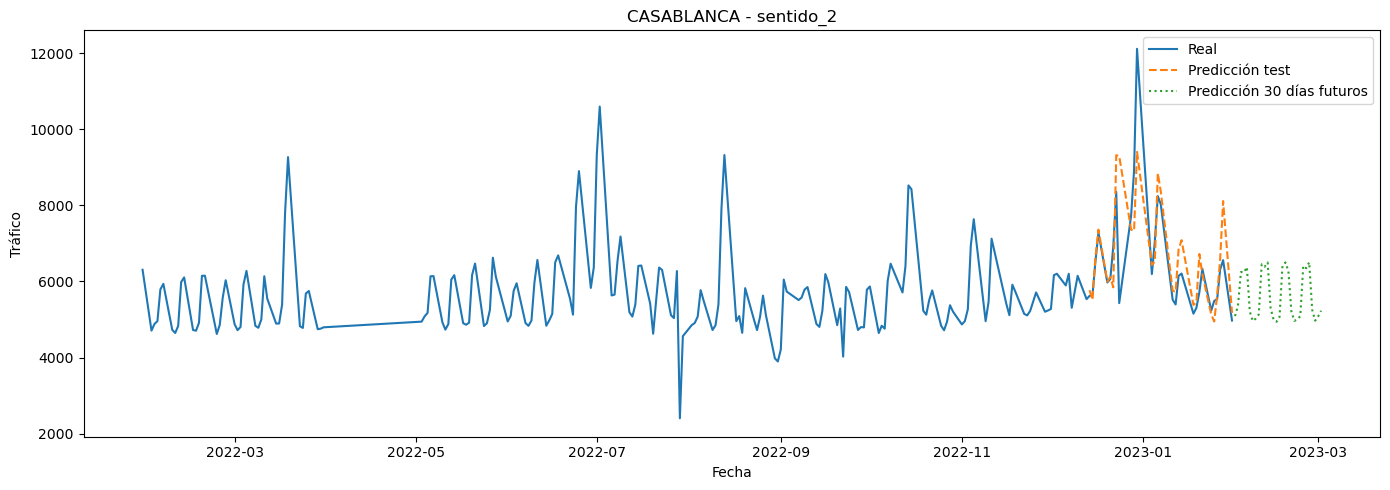


===== Entrenando modelo para CERRITOS II - sentido_1 =====
Mejores hiperparámetros para CERRITOS II - sentido_1: {'max_depth': 5, 'learning_rate': 0.03, 'n_estimators': 1000, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}
RMSE validación = 2581.37
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_cerritos_ii_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_cerritos_ii_sentido_1.csv


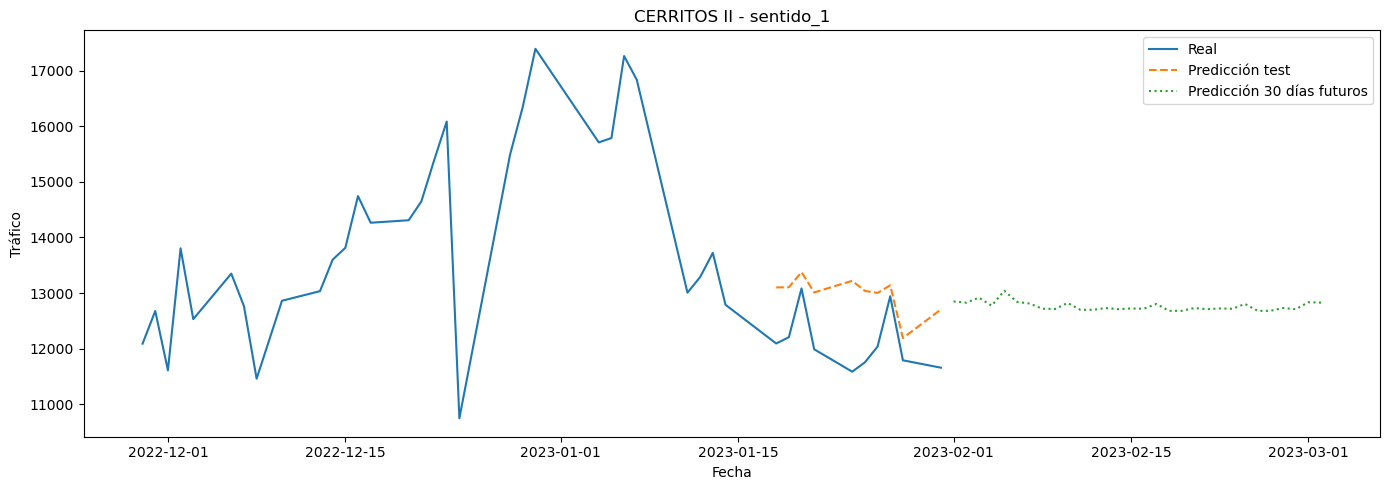


===== Entrenando modelo para CERRITOS II - sentido_2 =====
Mejores hiperparámetros para CERRITOS II - sentido_2: {'max_depth': 5, 'learning_rate': 0.03, 'n_estimators': 1000, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}
RMSE validación = 1512.59
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_cerritos_ii_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_cerritos_ii_sentido_2.csv


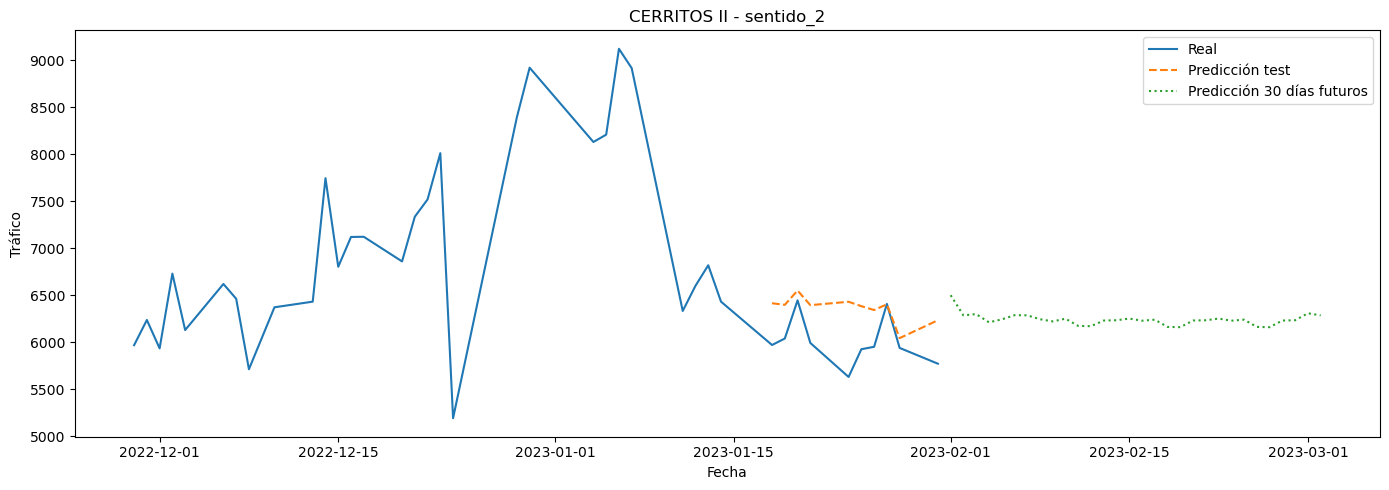


===== Entrenando modelo para LA PARADA - sentido_1 =====
Mejores hiperparámetros para LA PARADA - sentido_1: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 1122.89
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_la_parada_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_la_parada_sentido_1.csv


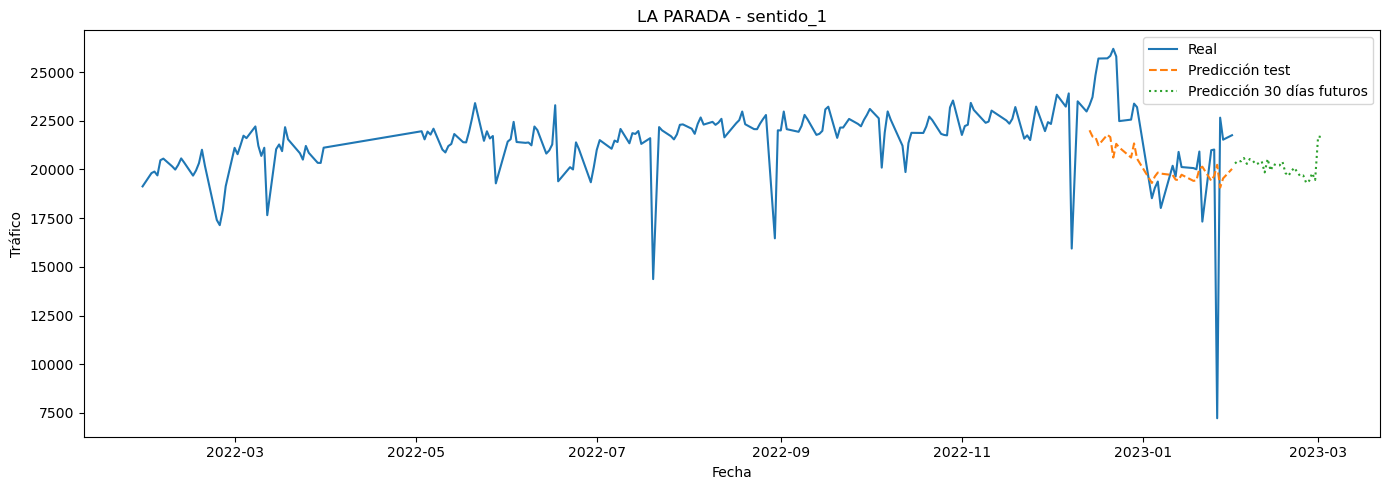


===== Entrenando modelo para LA PARADA - sentido_2 =====
Mejores hiperparámetros para LA PARADA - sentido_2: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 18600.35
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_la_parada_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_la_parada_sentido_2.csv


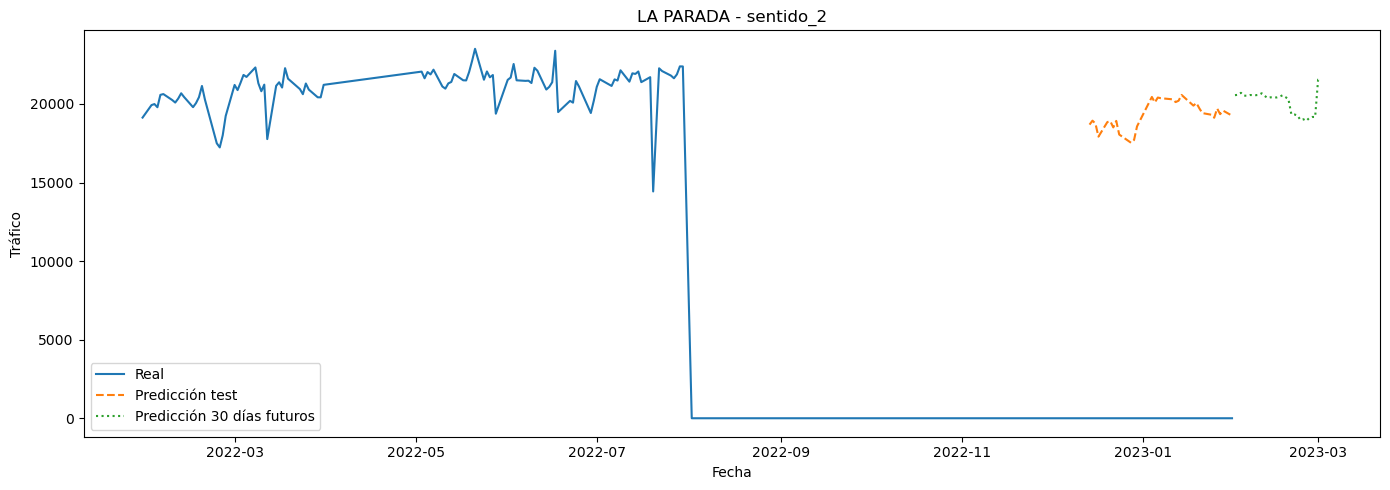


===== Entrenando modelo para PEAJE TUNEL LA LINEA QUINDIO - sentido_1 =====
Mejores hiperparámetros para PEAJE TUNEL LA LINEA QUINDIO - sentido_1: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 338.49
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_peaje_tunel_la_linea_quindio_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_peaje_tunel_la_linea_quindio_sentido_1.csv


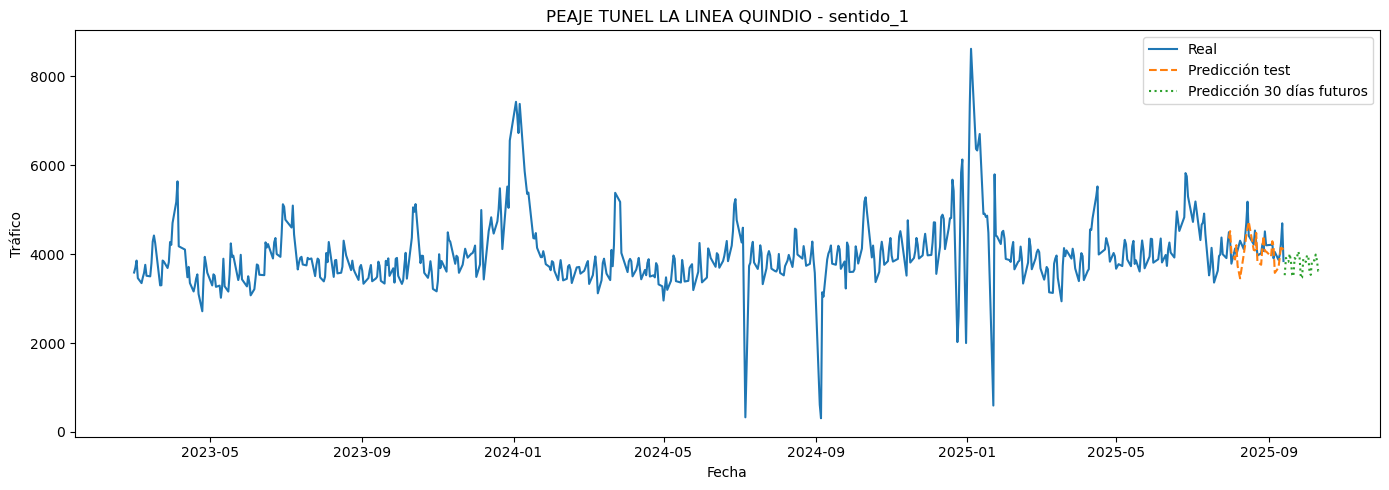


===== Entrenando modelo para PEAJE TUNEL LA LINEA QUINDIO - sentido_2 =====
[PEAJE TUNEL LA LINEA QUINDIO - sentido_2] Sin variación suficiente, se omite.

===== Entrenando modelo para PEAJE TUNEL LA LINEA TOLIMA - sentido_1 =====
Mejores hiperparámetros para PEAJE TUNEL LA LINEA TOLIMA - sentido_1: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 379.17
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_peaje_tunel_la_linea_tolima_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_peaje_tunel_la_linea_tolima_sentido_1.csv


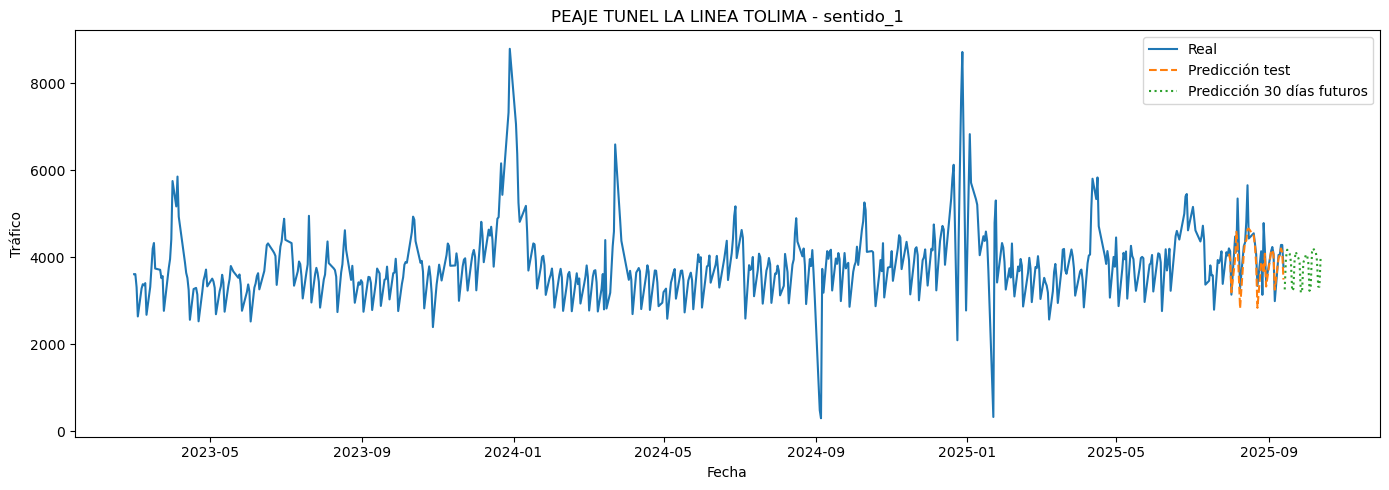


===== Entrenando modelo para PEAJE TUNEL LA LINEA TOLIMA - sentido_2 =====
Mejores hiperparámetros para PEAJE TUNEL LA LINEA TOLIMA - sentido_2: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 379.17
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_peaje_tunel_la_linea_tolima_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_peaje_tunel_la_linea_tolima_sentido_2.csv


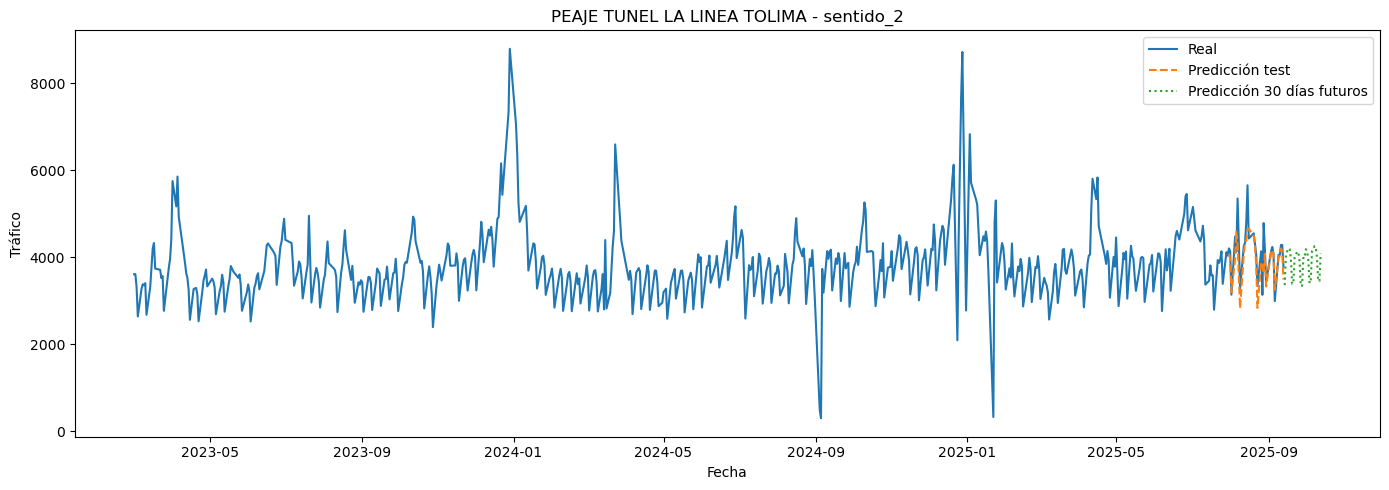


===== Entrenando modelo para PTO. TRIUNFO - sentido_1 =====
Mejores hiperparámetros para PTO. TRIUNFO - sentido_1: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 498.00
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_pto_triunfo_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_pto_triunfo_sentido_1.csv


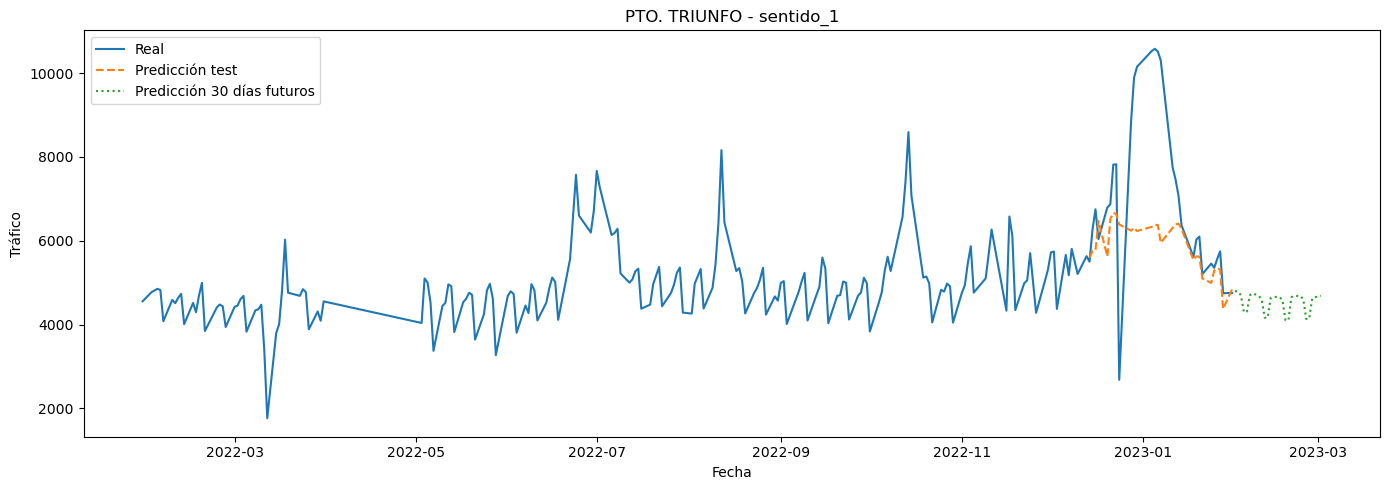


===== Entrenando modelo para PTO. TRIUNFO - sentido_2 =====
Mejores hiperparámetros para PTO. TRIUNFO - sentido_2: {'max_depth': 5, 'learning_rate': 0.03, 'n_estimators': 1000, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3, 'gamma': 0.1}
RMSE validación = 348.71
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_pto_triunfo_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_pto_triunfo_sentido_2.csv


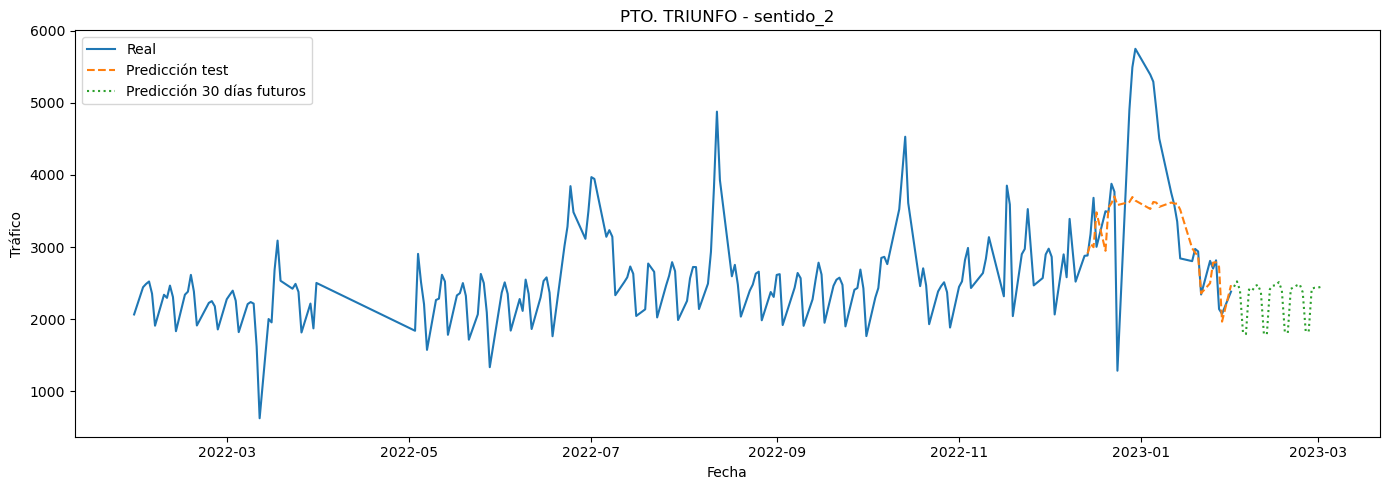


===== Entrenando modelo para SACHICA - sentido_1 =====
Mejores hiperparámetros para SACHICA - sentido_1: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 800.47
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_sachica_sentido_1.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_sachica_sentido_1.csv


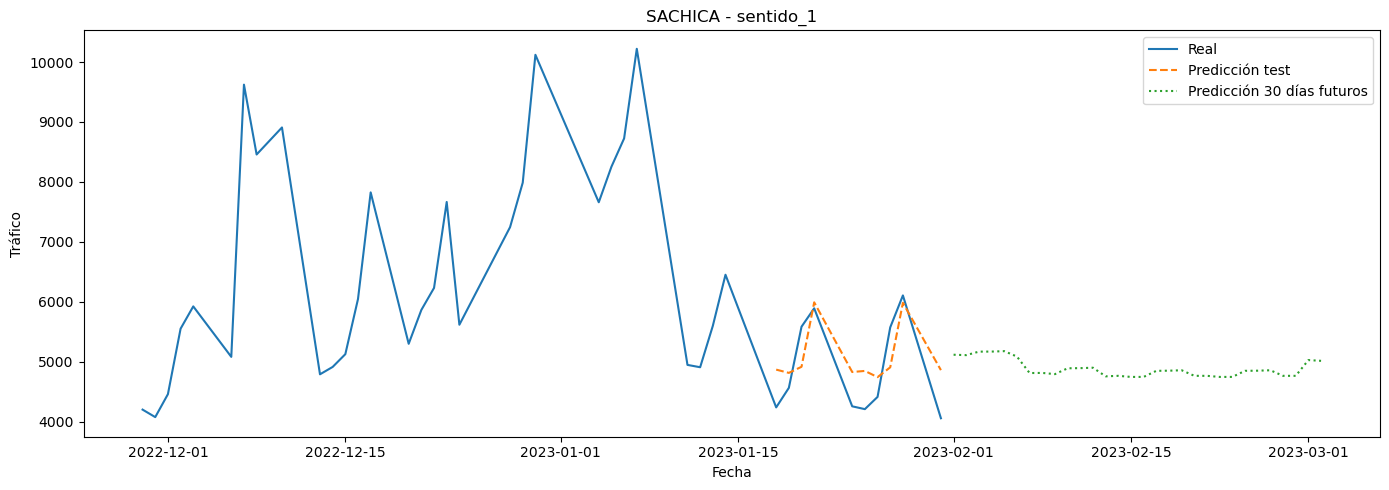


===== Entrenando modelo para SACHICA - sentido_2 =====
Mejores hiperparámetros para SACHICA - sentido_2: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 722.82
Modelo guardado en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/xgb_sachica_sentido_2.joblib
Resultados detallados guardados en: /Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_sachica_sentido_2.csv


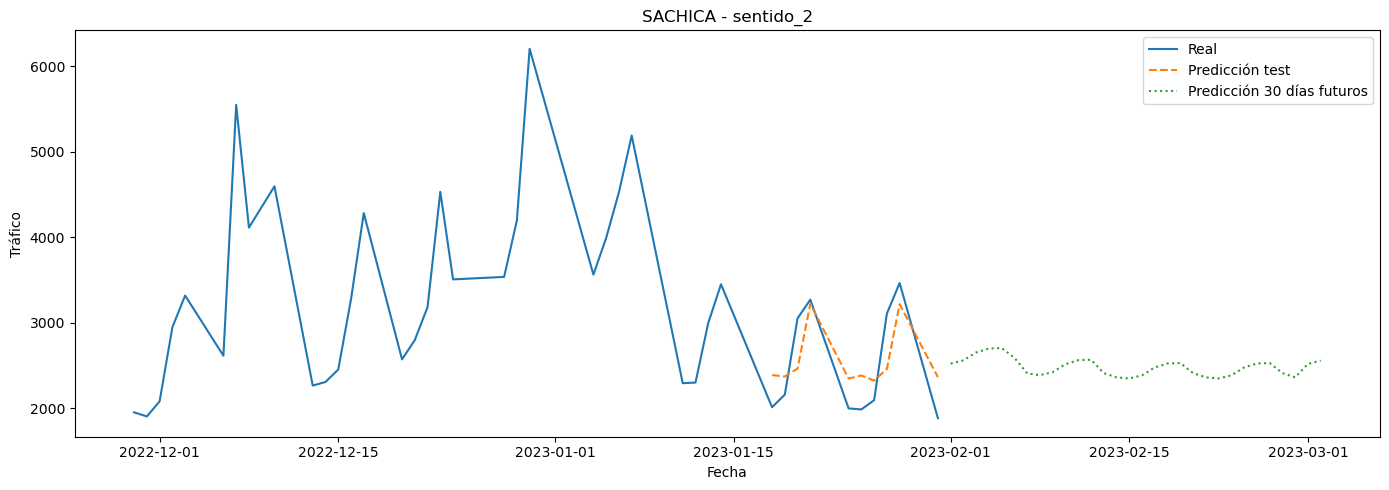

CPU times: user 1min 49s, sys: 50.9 s, total: 2min 40s
Wall time: 20.1 s


In [49]:

%%time
from datetime import datetime, timedelta
peajes = df_feat['peaje'].unique()
print("Peajes a modelar:", peajes)

all_results = []

models = {}  # dict[(peaje, target)] = modelo
feature_sets = {}  # dict[(peaje, target)] = feature_cols

for peaje in peajes:
    df_p = df_feat[df_feat['peaje'] == peaje].copy()

    for target_col in ['sentido_1', 'sentido_2']:
        if target_col not in df_p.columns:
            continue

        print(f"\n===== Entrenando modelo para {peaje} - {target_col} =====")

        result = train_xgb_with_tuning(df_p, target_col, use_gpu=False)
        if result is None:
            continue

        model, metrics, splits = result
        feature_cols = splits["feature_cols"]

        # Guardar modelo con nombre apropiado
        peaje_slug = slugify(peaje)
        sentido_slug = target_col
        model_name = f"xgb_{peaje_slug}_{sentido_slug}"
        model_path = f"/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/{model_name}.joblib"

        dump(model, model_path)
        print(f"Modelo guardado en: {model_path}")

        models[(peaje, target_col)] = model
        feature_sets[(peaje, target_col)] = feature_cols

        # Construir df_peaje_full (con recorte de ceros) para forecasting
        df_p_trim = trim_zeros_begin_end(df_p, col='total')
        df_p_trim = df_p_trim.sort_values('fecha').reset_index(drop=True)

        # Forecast 30 días futuros
        future_df = forecast_future_days(df_p_trim, model, target_col, feature_cols, horizon=30)

        # DataFrame completo con info de train/val/test/future
        full_df = build_full_results_df(df_p_trim, target_col, splits, future_df, metrics, model_name)

        # Guardar CSV específico por modelo
        csv_name = f"resultados_{peaje_slug}_{sentido_slug}.csv"
        csv_path = f"/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/{csv_name}"
        full_df.to_csv(csv_path, index=False)
        print(f"Resultados detallados guardados en: {csv_path}")

        all_results.append(full_df)

        # Graficar resultados para este modelo
        plot_results(full_df, peaje, target_col)

## Se saca un resumen de las metricas 

In [52]:
if len(all_results) > 0:
    resumen_list = []
    for df_res in all_results:
        row = {
            "modelo": df_res['modelo'].iloc[0],
            "peaje": df_res['peaje'].iloc[0],
            "target": df_res['target'].iloc[0],
            "rmse_train": df_res['rmse_train'].iloc[0],
            "mae_train": df_res['mae_train'].iloc[0],
            "rmse_val": df_res['rmse_val'].iloc[0],
            "mae_val": df_res['mae_val'].iloc[0],
            "rmse_test": df_res['rmse_test'].iloc[0],
            "mae_test": df_res['mae_test'].iloc[0],
            "smape_val": df_res['smape_val'].iloc[0],
            "smape_test": df_res['smape_test'].iloc[0],
            "mase_val": df_res['mase_val'].iloc[0],
            "mase_test": df_res['mase_test'].iloc[0],
        }
        resumen_list.append(row)

    resumen_df = pd.DataFrame(resumen_list)
    resumen_df = resumen_df.sort_values(['peaje', 'target'])

    display(resumen_df)

    resumen_df.to_csv("/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resumen_metricas_modelos.csv", index=False)
    print("Resumen de métricas guardado en /content/resumen_metricas_modelos.csv")

,modelo,peaje,target,rmse_train,mae_train,rmse_val,mae_val,rmse_test,mae_test,smape_val,smape_test,mase_val,mase_test
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,88.712875,70.542984,1535.371209,1232.140869,518.363350,421.571381,40.905178,17.312782,1.339284,0.458230
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,49.854598,41.872944,944.775370,700.206848,260.799657,196.434769,41.444238,15.287921,1.119630,0.314099
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,0.004067,0.003502,840.037313,606.724365,1510.247993,1020.508850,5.789705,8.324021,0.438381,0.737356
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,6.151774,3.819109,726.071062,491.768494,1051.832924,641.279480,8.877016,8.815249,0.408010,0.532056
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,7.575405,4.591699,2581.370760,2127.078125,974.641569,874.917480,15.013307,7.017968,1.065578,0.438297
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,2.541504,1.990576,1512.590576,1235.201172,415.259821,352.761719,17.290304,5.759608,1.088366,0.310827
6,xgb_la_parada_sentido_1,LA PARADA,sentido_1,8.903332,7.299864,1122.886515,810.119690,3397.605627,2377.843506,3.722828,12.059275,0.740504,2.173510
7,xgb_la_parada_sentido_2,LA PARADA,sentido_2,9.238612,5.381609,18600.347524,18290.300781,19326.945335,19308.466797,193.481291,200.000000,12.254357,12.936519
8,xgb_peaje_tunel_la_linea_quindio_sentido_1,PEAJE TUNEL LA LINEA QUINDIO,sentido_1,86.691491,64.916862,338.488748,250.665237,324.997392,271.407074,6.050004,6.511795,0.389888,0.422150
9,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,82.153840,62.220554,379.172083,270.214783,434.219289,298.253265,6.830917,7.355651,0.353670,0.390368


Resumen de métricas guardado en /content/resumen_metricas_modelos.csv


## Metricas extendidas

In [54]:
import glob
import numpy as np
import pandas as pd

files = glob.glob("/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_*.csv")
rows = []

for path in files:
    df_mod = pd.read_csv(path)

    modelo = df_mod.loc[0, 'modelo']
    peaje = df_mod.loc[0, 'peaje']
    target = df_mod.loc[0, 'target']

    rmse_test = df_mod.loc[0, 'rmse_test']
    mae_test  = df_mod.loc[0, 'mae_test']

    # Serie real en test
    mask_test = df_mod['set'] == 'test'
    y_test = df_mod.loc[mask_test, 'y_real'].dropna()

    if len(y_test) > 0:
        mean_y_test = y_test.abs().mean()
        range_y_test = y_test.max() - y_test.min()
    else:
        mean_y_test = np.nan
        range_y_test = np.nan

    rmse_pct_mean = rmse_test / mean_y_test * 100 if mean_y_test else np.nan
    mae_pct_mean  = mae_test / mean_y_test * 100 if mean_y_test else np.nan
    rmse_pct_range = rmse_test / range_y_test * 100 if range_y_test else np.nan

    rows.append({
        "modelo": modelo,
        "peaje": peaje,
        "target": target,
        "rmse_pct_mean": rmse_pct_mean,
        "mae_pct_mean": mae_pct_mean,
        "rmse_pct_range": rmse_pct_range
    })

df_ext = pd.DataFrame(rows).sort_values(["peaje", "target"]).reset_index(drop=True)
df_ext

,modelo,peaje,target,rmse_pct_mean,mae_pct_mean,rmse_pct_range
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,20.537375,16.702511,54.108909
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,20.182608,15.201576,42.064461
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,12.679652,8.567929,16.311135
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,16.100059,9.815853,14.733617
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,8.045646,7.222426,65.106317
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,6.913047,5.872608,50.952125
6,xgb_la_parada_sentido_1,LA PARADA,sentido_1,15.874634,11.109999,17.909470
7,xgb_la_parada_sentido_2,LA PARADA,sentido_2,NaN,NaN,NaN
8,xgb_peaje_tunel_la_linea_quindio_sentido_1,PEAJE TUNEL LA LINEA QUINDIO,sentido_1,7.679764,6.413413,23.314017
9,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,10.502764,7.214059,16.287295


Archivos encontrados: ['/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_bicentenario_sentido_1.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_bicentenario_sentido_2.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_sachica_sentido_2.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_cerritos_ii_sentido_1.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_sachica_sentido_1.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_cerritos_ii_sentido_2.csv', '/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_peaje_tunel_la_linea_tolima_sentido_2.

,modelo,peaje,target,mae_norm_pct,rmse_norm_pct
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,16.702511,20.537375
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,15.201576,20.182608
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,8.567929,12.679652
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,9.815853,16.100059
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,7.222426,8.045646
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,5.872608,6.913047
6,xgb_la_parada_sentido_1,LA PARADA,sentido_1,11.109999,15.874634
7,xgb_la_parada_sentido_2,LA PARADA,sentido_2,inf,inf
8,xgb_peaje_tunel_la_linea_quindio_sentido_1,PEAJE TUNEL LA LINEA QUINDIO,sentido_1,6.413413,7.679764
9,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,7.214059,10.502764


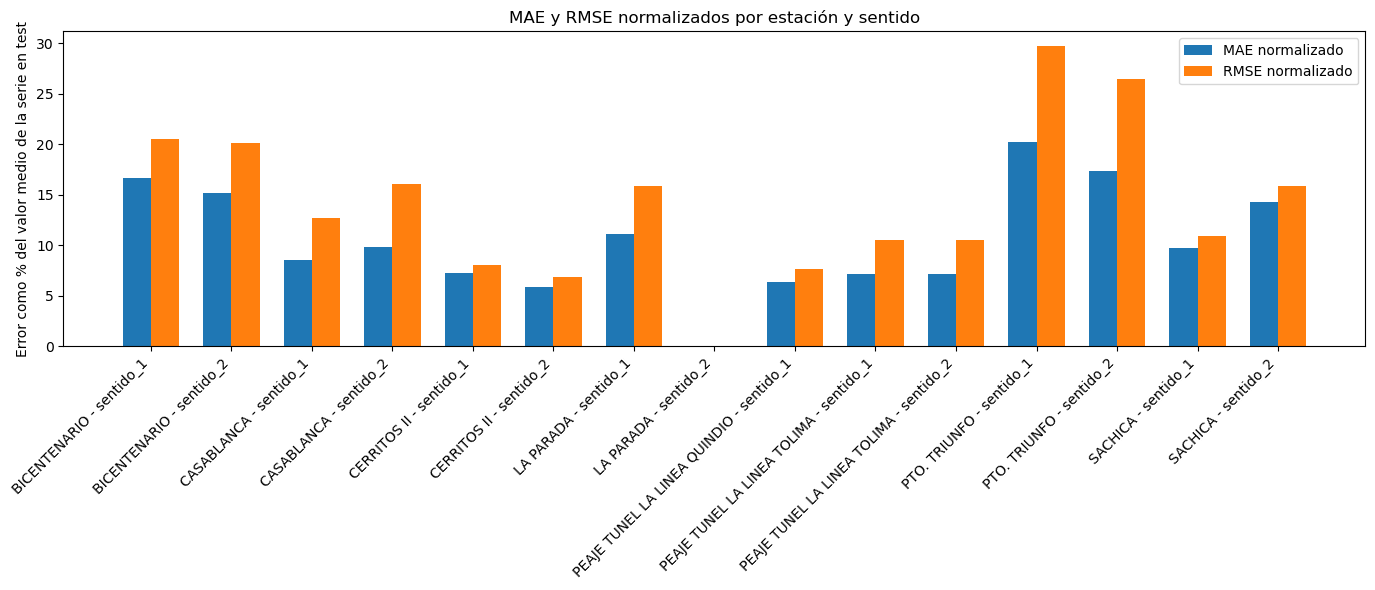

In [56]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar resultados_*.csv y construir tabla con métricas + escala de cada serie
files = glob.glob("/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resultados_*.csv")
print("Archivos encontrados:", files)

rows = []

for path in files:
    df_mod = pd.read_csv(path)

    modelo = df_mod.loc[0, 'modelo']
    peaje = df_mod.loc[0, 'peaje']
    target = df_mod.loc[0, 'target']

    mae_test = df_mod.loc[0, 'mae_test']
    rmse_test = df_mod.loc[0, 'rmse_test']

    # Serie real de test para tener la escala
    mask_test = df_mod['set'] == 'test'
    y_test = df_mod.loc[mask_test, 'y_real'].dropna()

    if len(y_test) == 0:
        continue

    mean_y_test = y_test.abs().mean()

    rows.append({
        "modelo": modelo,
        "peaje": peaje,
        "target": target,
        "mae_test": mae_test,
        "rmse_test": rmse_test,
        "mean_y_test": mean_y_test,
    })

df_ext = pd.DataFrame(rows)

# 2. Ordenar y crear etiqueta "peaje - sentido"
df_ext = df_ext.sort_values(["peaje", "target"]).reset_index(drop=True)
df_ext["label"] = df_ext["peaje"] + " - " + df_ext["target"]

# 3. Normalizar MAE y RMSE por el valor medio de la serie en test (en %)
df_ext["mae_norm_pct"] = df_ext["mae_test"] / df_ext["mean_y_test"] * 100
df_ext["rmse_norm_pct"] = df_ext["rmse_test"] / df_ext["mean_y_test"] * 100

display(df_ext[["modelo", "peaje", "target", "mae_norm_pct", "rmse_norm_pct"]])

# 4. Gráfico conjunto MAE y RMSE normalizados
x = np.arange(len(df_ext))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x - width/2, df_ext["mae_norm_pct"], width, label="MAE normalizado")
ax.bar(x + width/2, df_ext["rmse_norm_pct"], width, label="RMSE normalizado")

ax.set_xticks(x)
ax.set_xticklabels(df_ext["label"], rotation=45, ha="right")
ax.set_ylabel("Error como % del valor medio de la serie en test")
ax.set_title("MAE y RMSE normalizados por estación y sentido")
ax.legend()
plt.tight_layout()
plt.show()

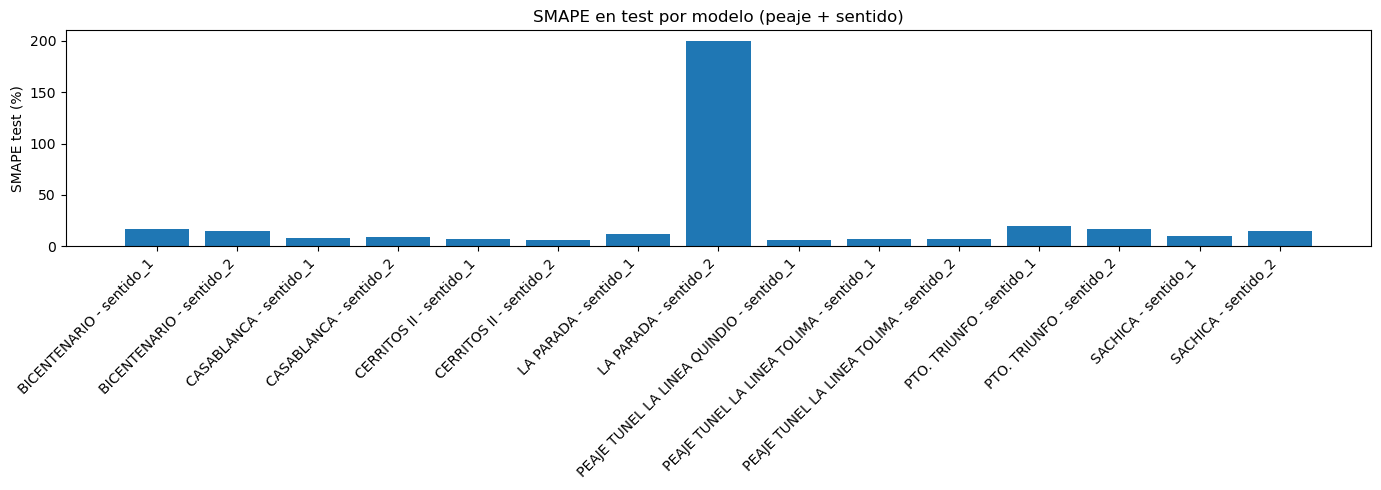

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen que ya generaste con todas las métricas
resumen_path = "/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resumen_metricas_modelos.csv"
df_res = pd.read_csv(resumen_path)

# Etiqueta peaje - sentido
df_res["label"] = df_res["peaje"] + " - " + df_res["target"]

plt.figure(figsize=(14, 5))
plt.xticks(rotation=45, ha='right')

plt.bar(df_res['label'], df_res['smape_test'])
plt.ylabel("SMAPE test (%)")
plt.title("SMAPE en test por modelo (peaje + sentido)")
plt.tight_layout()
plt.show()

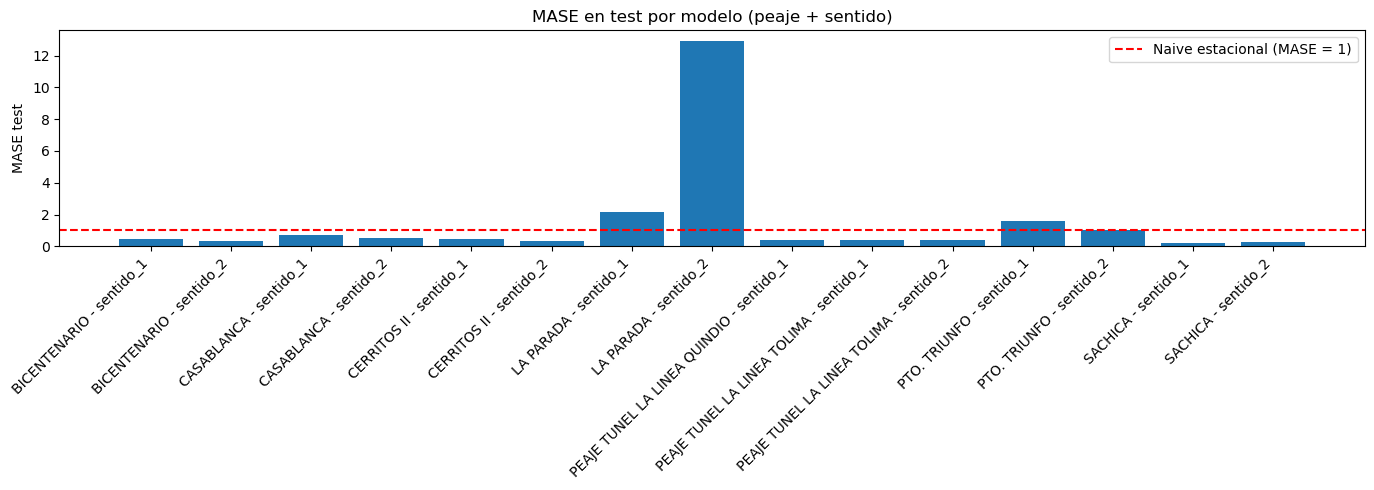

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen con todas las métricas
resumen_path = "/Users/nicolasalonsogonzalezochoa/Documents/NAGO/00_ACADEMICO/00_MINE/CienciaDeDatos/ProyectoFinal/resumen_metricas_modelos.csv"
df_res = pd.read_csv(resumen_path)

# Etiqueta peaje - sentido
df_res["label"] = df_res["peaje"] + " - " + df_res["target"]

plt.figure(figsize=(14, 5))
plt.xticks(rotation=45, ha='right')

plt.bar(df_res['label'], df_res['mase_test'])
plt.axhline(1.0, color='red', linestyle='--', label='Naive estacional (MASE = 1)')

plt.ylabel("MASE test")
plt.title("MASE en test por modelo (peaje + sentido)")
plt.legend()
plt.tight_layout()
plt.show()